# Causal Inference for Churn Test: Breadth of Engagement AB Test Results Analysis

## Preparation

### Dependencies

pip install snowflake-snowpark-python
pip install pandas
pip install doubleml
pip install scikit-learn
pip install "snowflake-connector-python[pandas]"

### Import Libraries

In [2]:
#Snowflake Connections
import boto3
import json
import pandas as pd
from snowflake.snowpark import Session
import yaml
import numpy as np

#DoubleML Model Libraries
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split
from doubleml import DoubleMLData
from doubleml import DoubleMLPLR

#OLS Model
import statsmodels.api as sm
import statsmodels.formula.api as smf

#sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

#plots
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image

#Uplift Modeling
from sklearn.model_selection import train_test_split
from causalml.inference.tree import UpliftRandomForestClassifier
from causalml.inference.tree import uplift_tree_string, uplift_tree_plot
from causalml.metrics import plot_gain
from causalml.metrics import auuc_score
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

## Import Data from Snowflake

### A/B Test Data

In [3]:
# Get Snowflake credentials from AWS Secrets Manager
SECRET_NAME = "secretname" 

session = boto3.session.Session()
client = session.client(
    service_name='secretsmanager'
)


get_secret_value_response = client.get_secret_value(SecretId=SECRET_NAME)
secret = get_secret_value_response['SecretString']
snf_config = json.loads(secret)

# Create Snowflake connection
session = Session.builder.configs(snf_config).create()

query = f"""
with audience as (
    select *
    from SBX.EMILYY_BREATH_CONTROL_TEST_GROUP_NOV24
),

-- Section reads in the 30 days before the email
pre_email_section_counts as (
    select 
        A.RECIPIENT_CONTACT_ID,
        count(distinct B.SECTION_NAME) as sections_read_prev_1m
    from audience A
    left join SBX.LE_VW_SECTIONS_TEST B 
        on A.RECIPIENT_CONTACT_ID = B.USER_ID
       and B.DAY_DATE >= dateadd('day', -30, '2024-09-27')
       and B.DAY_DATE < '2024-09-27'
    group by 1
),

-- Users with < 2 sections read before the email
pre_email_engaged as (
    select *
    from pre_email_section_counts
    where coalesce(sections_read_prev_1m, 0) < 2
),

-- Active Annual subscribers on the email date
active_entitlement as (
    select A.*,
           B.ENTITLEMENT_KEY,
           B.ENTITLEMENT_PRODUCT_NAME,
           B.ENTITLEMENT_RATEPLAN_TERM,
           B.ENTITLEMENT_RECIPIENT_REGION_CODE,
           B.SUBSCRIBER_TENURE_YEARS
    from audience A
    left join DERIVED.FACT_ENTITLEMENT_DAILY_ACTIVE B
        on A.RECIPIENT_CONTACT_ID = B.RECIPIENT_CONTACT_ID
       and B.ENTITLEMENT_PRODUCT_NAME = 'TE.DIGITAL'
       and B.ENTITLEMENT_RATEPLAN_TERM = 'Annual'
       and B.CALENDAR_DATE = '2024-09-27'
),

-- Final targeting group
targeted_audience as (
    select A.*
    from active_entitlement A
    inner join pre_email_engaged P
        on A.RECIPIENT_CONTACT_ID = P.RECIPIENT_CONTACT_ID
),

-- Ensure entitlement was valid a month before
entitlement_filter as (
    select A.*
    from targeted_audience A
    left join DERIVED.FACT_ENTITLEMENT B
        on A.ENTITLEMENT_KEY = B.ENTITLEMENT_KEY
       and B.ENTITLEMENT_EFFECTIVE_START_DATE <= dateadd('month', -1, '2024-09-27')
),

-- Section reads in 2 weeks after the email
section_counts_fwd_2w as (
    select 
        A.RECIPIENT_CONTACT_ID,
        count(distinct B.SECTION_NAME) as sections_read_fwd_2w,
        listagg(distinct B.SECTION_NAME, ', ') as section_names_fwd_2w,
        case 
            when listagg(distinct B.SECTION_NAME, ', ') ilike '%culture%' 
            then count(distinct B.SECTION_NAME) - 1
            else count(distinct B.SECTION_NAME) 
        end as sections_read_wo_culture_2w
    from audience A
    left join SBX.LE_VW_SECTIONS_TEST B 
        on A.RECIPIENT_CONTACT_ID = B.USER_ID
       and B.DAY_DATE >= '2024-09-27'
       and B.DAY_DATE <= dateadd('week', 2, '2024-09-27')
    group by 1
),

-- Join pre and post read counts
joinback as (
    select 
        A.*,
        s2w.sections_read_fwd_2w,
        s2w.section_names_fwd_2w,
        s2w.sections_read_wo_culture_2w,
        p.sections_read_prev_1m
    from entitlement_filter A
    left join section_counts_fwd_2w s2w 
        on A.RECIPIENT_CONTACT_ID = s2w.RECIPIENT_CONTACT_ID
    left join pre_email_section_counts p
        on A.RECIPIENT_CONTACT_ID = p.RECIPIENT_CONTACT_ID
),

-- Add engagement bands
engagement as (
    select 
        A.*,
        B.engagement_score,
        case 
            when B.ENGAGEMENT_SCORE < 0.1 then 'Very Low'
            when B.ENGAGEMENT_SCORE < 0.5 then 'Low'
            when B.ENGAGEMENT_SCORE < 0.9 then 'Medium'
            else 'High' 
        end as engagement_score_band
    from joinback A
    left join DERIVED.FACT_CUSTOMER_ENGAGEMENT_ROLLING B
        on A.ENTITLEMENT_KEY = B.ENTITLEMENT_KEY
       and B.ROLLING_FLAG = 'ROLLING_30'
       and B.CALENDAR_DATE = '2024-09-27'
)

-- Final metrics: annual_2_reads + pre and post section counts
select 
    ENTITLEMENT_KEY,
    CONTROL_TEST,
    SUBSCRIBER_TENURE_YEARS,
    engagement_score_band,
    sum(sections_read_prev_1m) as total_sections_read_prev_1m,
    sum(sections_read_fwd_2w) as total_sections_read_fwd_2w,
    count(distinct case when sections_read_fwd_2w >= 2 then RECIPIENT_CONTACT_ID end) * 1.0 / count(distinct RECIPIENT_CONTACT_ID) as annual_2_reads
from engagement
group by 
    CONTROL_TEST,
    SUBSCRIBER_TENURE_YEARS,
    engagement_score_band,
    ENTITLEMENT_KEY
"""


try:
    df = session.sql(query).to_pandas()
finally:
    session.close()

df

,ENTITLEMENT_KEY,CONTROL_TEST,SUBSCRIBER_TENURE_YEARS,ENGAGEMENT_SCORE_BAND,TOTAL_SECTIONS_READ_PREV_1M,TOTAL_SECTIONS_READ_FWD_2W,ANNUAL_2_READS
0,1.799330e+19,TEST,Y4,Low,1,0,0.0
1,3.880818e+18,CONTROL,Y1,Medium,0,1,0.0
2,9.539141e+18,CONTROL,Y5+,Very Low,0,0,0.0
3,3.901115e+18,TEST,Y5+,Very Low,0,0,0.0
4,6.264435e+18,TEST,Y5+,Very Low,0,0,0.0
...,...,...,...,...,...,...,...
130827,1.308690e+19,CONTROL,Y2,Very Low,0,0,0.0
130828,4.150208e+18,TEST,Y5+,Low,0,0,0.0
130829,1.061301e+19,CONTROL,Y1,Low,0,0,0.0
130830,5.996247e+18,TEST,Y2,Very Low,0,0,0.0


### Customer Behaviour Data

In [4]:
query = f"""
  with audience as (
    select *
    from SBX.EMILYY_BREATH_CONTROL_TEST_GROUP_NOV24
),

active_entitlement as (
    select A.*,
           B.ENTITLEMENT_KEY,
           B.ENTITLEMENT_PRODUCT_NAME,
           B.ENTITLEMENT_RATEPLAN_TERM,
           B.ENTITLEMENT_RECIPIENT_REGION_CODE,
           B.SUBSCRIBER_TENURE_YEARS
    from audience A
    left join DERIVED.FACT_ENTITLEMENT_DAILY_ACTIVE B
      on A.RECIPIENT_CONTACT_ID = B.RECIPIENT_CONTACT_ID
     and B.ENTITLEMENT_PRODUCT_NAME = 'TE.DIGITAL'
     and B.ENTITLEMENT_RATEPLAN_TERM in ('Annual')
     and B.CALENDAR_DATE = '2024-09-27'
),

entitlement_filter as (
    select A.ENTITLEMENT_KEY
    from active_entitlement A
    left join DERIVED.FACT_ENTITLEMENT B
      on A.ENTITLEMENT_KEY = B.ENTITLEMENT_KEY
     and B.ENTITLEMENT_EFFECTIVE_START_DATE <= dateadd('month', -1, '2024-09-27')
)

select *
from DERIVED.FACT_CUSTOMER_ENGAGEMENT_ROLLING
where ROLLING_FLAG = 'ROLLING_30'
  and CALENDAR_DATE = '2024-09-27'
  and ENTITLEMENT_KEY in (
      select distinct ENTITLEMENT_KEY
      from entitlement_filter
  );


"""
session = Session.builder.configs(snf_config).create()

try:
    df_entitlement = session.sql(query).to_pandas()
finally:
    session.close()

df_entitlement

,SF_CONTACT_ID,CALENDAR_DATE,ENTITLEMENT_KEY,ENTITLEMENT_RECIPIENT_REGION_CODE,ENTITLEMENT_RECIPIENT_COUNTRY,ENTITLEMENT_TYPE,ENTITLEMENT_CONTRACT_TYPE,ENTITLEMENT_PRODUCT_NAME,ENTITLEMENT_RATEPLAN_TERM,ENTITLEMENT_GIFT_FLAG,...,COREAPP_AUDIO_PLAY_REGULAR_CNT,COREAPP_AUDIO_PLAY_PODCAST_CNT,COREAPP_VIDEO_PLAY_REGULAR_CNT,ESPRESSOAPP_ARTICLE_REGULAR_VIEW_CNT,ESPRESSOAPP_ARTICLE_ESPRESSO_VIEW_CNT,ESPRESSOAPP_ARTICLE_INTERACTIVE_VIEW_CNT,ESPRESSOAPP_AUDIO_PLAY_REGULAR_CNT,ESPRESSOAPP_AUDIO_PLAY_PODCAST_CNT,ESPRESSOAPP_VIDEO_PLAY_REGULAR_CNT,SUBSCRIBER_TENURE_YEARS
0,0033z000034DMXnAAO,2024-09-27,3.042116e+18,CEMEA,Spain,Direct,AR,TE.DIGITAL,Annual,Owned,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None
1,0033z00003522scAAA,2024-09-27,1.336871e+19,CEMEA,South Africa,Direct,AR,TE.DIGITAL,Annual,Owned,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None
2,0033z00002qd7PZAAY,2024-09-27,1.117353e+19,NA,United States,Direct,AR,TE.DIGITAL,Annual,Owned,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None
3,0033z00003O7252AAB,2024-09-27,1.643449e+19,CEMEA,Kenya,Direct,AR,TE.DIGITAL,Annual,Owned,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None
4,0033z00002st24KAAQ,2024-09-27,2.047709e+18,NA,United States,Direct,AR,TE.DIGITAL,Annual,Owned,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131343,0033z00002rvTOVAA2,2024-09-27,1.505375e+19,CEMEA,Italy,Direct,AR,TE.DIGITAL,Annual,Owned,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None
131344,0033z00003GDT50AAH,2024-09-27,1.371729e+18,CEMEA,Slovakia,Direct,AR,TE.DIGITAL,Annual,Owned,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None
131345,0033z00002otWm5AAE,2024-09-27,6.930528e+18,NA,United States,Direct,AR,TE.DIGITAL,Annual,Owned,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None
131346,0033z00003PUjpAAAT,2024-09-27,3.921797e+18,NA,United States,Direct,AR,TE.DIGITAL,Annual,Owned,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None


### Email Open and Click Data

In [5]:
query = f"""
select *, 
    case when FIRST_OPEN_DATETIME is not null then 1 else 0 end as open_flag,
    case when FIRST_CLICK_DATETIME is not null then 1 else 0 end as click_flag,
from DERIVED.DIM_COMMUNICATION
where COMM_EMAIL_NAME = 'r.ob.standard.core.all-eng.churn-test.all-term.global..breadth-test..'
and SEND_DATETIME::date = '2024-09-27'
"""

session = Session.builder.configs(snf_config).create()

try:
    df_email = session.sql(query).to_pandas()
finally:
    session.close()

df_email

,DIM_COMM_KEY,SF_CONTACT_ID,SF_CONTACT_KEY,SF_CUSTOMER_STATUS,SF_CONTACT_EMAIL_KEY,COMM_SUBSCRIBER_ID,COMM_SEND_ID,COMM_BATCH_ID,COMM_LIST_ID,LIST_NAME,...,SOURCE_SYSTEM,ROW_CREATED_DATETIME,ROW_UPDATED_DATETIME,ROW_CREATED_BY,ROW_UPDATED_BY,SLOT_ID,SUBMISSION_ID,COMM_EMAIL_NAME,OPEN_FLAG,CLICK_FLAG
0,1.638068e+19,0033z000035299JAAQ,8.671592e+18,Subscribed,6.943385e+18,238449566,1928033,10,119,None,...,SFMC_NEW,2024-09-29 09:02:11.610000+00:00,2024-09-29 09:02:11.610000+00:00,SERVICEUSER_PROD_AIRFLOW,SERVICEUSER_PROD_AIRFLOW,20240929,1,r.ob.standard.core.all-eng.churn-test.all-term...,0,0
1,1.807580e+19,0033z00002rvXr7AAE,1.490159e+19,Subscribed,2.014385e+18,249193228,1928033,206,119,None,...,SFMC_NEW,2024-09-29 09:02:11.610000+00:00,2024-09-29 09:02:11.610000+00:00,SERVICEUSER_PROD_AIRFLOW,SERVICEUSER_PROD_AIRFLOW,20240929,1,r.ob.standard.core.all-eng.churn-test.all-term...,0,0
2,1.376703e+19,0033z00002nUFZdAAO,1.274855e+19,Subscribed,1.836910e+19,235072154,1928033,290,119,None,...,SFMC_NEW,2024-09-29 09:02:11.610000+00:00,2024-09-29 09:02:11.610000+00:00,SERVICEUSER_PROD_AIRFLOW,SERVICEUSER_PROD_AIRFLOW,20240929,1,r.ob.standard.core.all-eng.churn-test.all-term...,0,0
3,1.596365e+19,0033z00002yI7XHAA0,9.730852e+18,Subscribed,1.325431e+19,273905281,1928033,45,119,None,...,SFMC_NEW,2024-09-29 09:02:11.610000+00:00,2024-09-29 09:02:11.610000+00:00,SERVICEUSER_PROD_AIRFLOW,SERVICEUSER_PROD_AIRFLOW,20240929,1,r.ob.standard.core.all-eng.churn-test.all-term...,1,0
4,1.276924e+19,0033z00003PTRAhAAP,1.455543e+19,Subscribed,3.745582e+18,271996731,1928033,247,119,None,...,SFMC_NEW,2024-09-29 09:02:11.610000+00:00,2024-09-29 09:02:11.610000+00:00,SERVICEUSER_PROD_AIRFLOW,SERVICEUSER_PROD_AIRFLOW,20240929,1,r.ob.standard.core.all-eng.churn-test.all-term...,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64459,3.214130e+18,0033z00003KHwGUAA1,1.556398e+19,Subscribed,6.273421e+18,265104390,1928033,197,119,None,...,SFMC_NEW,2024-09-29 09:02:11.610000+00:00,2024-09-29 09:02:11.610000+00:00,SERVICEUSER_PROD_AIRFLOW,SERVICEUSER_PROD_AIRFLOW,20240929,1,r.ob.standard.core.all-eng.churn-test.all-term...,0,0
64460,1.241908e+19,0033z00003QOu44AAD,3.999956e+18,Subscribed,2.412765e+18,272886419,1928033,751,119,None,...,SFMC_NEW,2024-09-29 09:02:11.610000+00:00,2024-09-29 09:02:11.610000+00:00,SERVICEUSER_PROD_AIRFLOW,SERVICEUSER_PROD_AIRFLOW,20240929,1,r.ob.standard.core.all-eng.churn-test.all-term...,0,0
64461,8.959846e+18,0033z00002y13TMAAY,9.545718e+18,Subscribed,9.376569e+18,239010480,1928033,365,119,None,...,SFMC_NEW,2024-09-29 09:02:11.610000+00:00,2024-09-29 09:02:11.610000+00:00,SERVICEUSER_PROD_AIRFLOW,SERVICEUSER_PROD_AIRFLOW,20240929,1,r.ob.standard.core.all-eng.churn-test.all-term...,0,0
64462,1.460342e+19,0033z00002rys8cAAA,1.231927e+19,Subscribed,1.497516e+19,207780085,1928033,700,119,None,...,SFMC_NEW,2024-09-29 09:02:11.610000+00:00,2024-09-29 09:02:11.610000+00:00,SERVICEUSER_PROD_AIRFLOW,SERVICEUSER_PROD_AIRFLOW,20240929,1,r.ob.standard.core.all-eng.churn-test.all-term...,0,0


## Data Wrangling

### Merging and Filtering

In [6]:
#Dataframe display settings
pd.set_option('display.max_rows', 100) 
pd.set_option('display.max_columns', None)  

#Merging A/B test data and Customer Behaviour data based on ENTITLEMENT_KEY
df_merged = df.merge(df_entitlement, on='ENTITLEMENT_KEY', how='left')

#Merging with email open and click data based on SF_CONTACT_ID
df_merged_complete = df_merged.merge(
    df_email[['SF_CONTACT_ID', 'CLICK_FLAG', 'OPEN_FLAG']],
    on='SF_CONTACT_ID',
    how='left'
)
df_merged_complete.to_csv('causal_inference_data.csv', index=False)
df_merged_complete

,ENTITLEMENT_KEY,CONTROL_TEST,SUBSCRIBER_TENURE_YEARS_x,ENGAGEMENT_SCORE_BAND,TOTAL_SECTIONS_READ_PREV_1M,TOTAL_SECTIONS_READ_FWD_2W,ANNUAL_2_READS,SF_CONTACT_ID,CALENDAR_DATE,ENTITLEMENT_RECIPIENT_REGION_CODE,ENTITLEMENT_RECIPIENT_COUNTRY,ENTITLEMENT_TYPE,ENTITLEMENT_CONTRACT_TYPE,ENTITLEMENT_PRODUCT_NAME,ENTITLEMENT_RATEPLAN_TERM,ENTITLEMENT_GIFT_FLAG,ENTITLEMENT_STUDENT_FLAG,ENTITLEMENT_TRIALIST_FLAG,ENTITLEMENT_FREE_FLAG,IS_DIGITAL_MONTHLY_FREE_TRIALIST_FLAG,ENTITLEMENT_RENEWAL_CATEGORY,SUBSCRIBER_TENURE_DAYS,TOTAL_SERVED_VOLUME,TOTAL_ENGAGEMENT_COUNT,WEBSITE_VISIT_CNT,WEBSITE_ARTICLE_VIEW_VISIT_CNT,WEBSITE_AUDIO_PLAY_VISIT_CNT,WEBSITE_VIDEO_PLAY_VISIT_CNT,WEBSITE_PAGE_VIEW_CNT,WEBSITE_ARTICLE_VIEW_CNT,WEBSITE_AUDIO_PLAY_CNT,WEBSITE_VIDEO_PLAY_CNT,WEBSITE_VIDEO_PLAY_WEBINAR_CNT,COREAPP_VISIT_CNT,COREAPP_ARTICLE_VIEW_VISIT_CNT,COREAPP_AUDIO_PLAY_VISIT_CNT,COREAPP_VIDEO_PLAY_VISIT_CNT,COREAPP_PAGE_VIEW_CNT,COREAPP_ARTICLE_VIEW_CNT,COREAPP_AUDIO_PLAY_CNT,COREAPP_VIDEO_PLAY_CNT,COREAPP_VIDEO_PLAY_WEBINAR_CNT,LEGACYAPP_VISIT_CNT,LEGACYAPP_ARTICLE_VIEW_VISIT_CNT,LEGACYAPP_AUDIO_PLAY_VISIT_CNT,LEGACYAPP_VIDEO_PLAY_VISIT_CNT,LEGACYAPP_PAGE_VIEW_CNT,LEGACYAPP_ARTICLE_VIEW_CNT,LEGACYAPP_AUDIO_PLAY_CNT,LEGACYAPP_VIDEO_PLAY_CNT,LEGACYAPP_VIDEO_PLAY_WEBINAR_CNT,ESPRESSOAPP_VISIT_CNT,ESPRESSOAPP_ARTICLE_VIEW_VISIT_CNT,ESPRESSOAPP_AUDIO_PLAY_VISIT_CNT,ESPRESSOAPP_VIDEO_PLAY_VISIT_CNT,ESPRESSOAPP_PAGE_VIEW_CNT,ESPRESSOAPP_ARTICLE_VIEW_CNT,ESPRESSOAPP_AUDIO_PLAY_CNT,ESPRESSOAPP_VIDEO_PLAY_CNT,ESPRESSOAPP_VIDEO_PLAY_WEBINAR_CNT,ESPRESSOLEGACYAPP_VISIT_CNT,ESPRESSOLEGACYAPP_ARTICLE_VIEW_VISIT_CNT,ESPRESSOLEGACYAPP_AUDIO_PLAY_VISIT_CNT,ESPRESSOLEGACYAPP_VIDEO_PLAY_VISIT_CNT,ESPRESSOLEGACYAPP_PAGE_VIEW_CNT,ESPRESSOLEGACYAPP_ARTICLE_VIEW_CNT,ESPRESSOLEGACYAPP_AUDIO_PLAY_CNT,ESPRESSOLEGACYAPP_VIDEO_PLAY_CNT,ESPRESSOLEGACYAPP_VIDEO_PLAY_WEBINAR_CNT,NEWSLETTER_CONTENT_OPEN_CNT,NEWSLETTER_CLICKBASED_OPEN_CNT,WEBINAR_ATTEND_CNT,ROLLING_FLAG,SLOT_ID,SUBMISSION_ID,ROW_CREATED_DATETIME,ROW_UPDATED_DATETIME,ROW_CREATED_BY,ROW_UPDATED_BY,ENTITLEMENT_PRODUCT_GRANULAR_NAME,NUMBER_OF_DAYS_ACTIVE,TOTAL_SECTION_READ_CNT,SECTION_LIST,ENGAGEMENT_SCORE,SCORE_WEIGHTED_CONSUMPTION,SCORE_COREAPP_ARTICLE,SCORE_COREAPP_AUDIO,SCORE_COREAPP_VIDEO,SCORE_WEBSITE_ARTICLE,SCORE_WEBSITE_AUDIO,SCORE_WEBSITE_VIDEO,SCORE_NEWSLETTER_CONTENT,SCORE_WEBINAR_ATTEND,SCORE_BREADTH,SCORE_FREQUENCY,WEIGHTED_CONSUMPTION,NEWSLETTER_ESPRESSO_OPEN_CNT,NEWSLETTER_COVERSTORY_OPEN_CNT,NEWSLETTER_MONEYTALKS_OPEN_CNT,NEWSLETTER_CHECKSANDBALANCE_OPEN_CNT,NEWSLETTER_CLIMATEISSUE_OPEN_CNT,NEWSLETTER_SIMPLYSCIENCE_OPEN_CNT,NEWSLETTER_OFFTHECHARTS_OPEN_CNT,NEWSLETTER_BOTTOMLINE_OPEN_CNT,NEWSLETTER_DRUMTOWER_OPEN_CNT,NEWSLETTER_BLIGHTY_OPEN_CNT,NEWSLETTER_ANALYSING_AFRICA_OPEN_CNT,NEWSLETTER_EXTRAORDINARYSTORY_OPEN_CNT,NEWSLETTER_WARROOM_OPEN_CNT,NEWSLETTER_ECONOMISTTODAY_OPEN_CNT,NEWSLETTER_ECONOMISTTODAY_SUNDAY_OPEN_CNT,NEWSLETTER_THISWEEK_OPEN_CNT,NEWSLETTER_THISWEEK_SATURDAY_OPEN_CNT,NEWSLETTER_ESSENTIALINDIA_OPEN_CNT,NEWSLETTER_CAFEEUROPA_OPEN_CNT,NEWSLETTER_MIDDLE_EAST_DISPATCH_OPEN_CNT,NEWSLETTER_EL_BOLETIN_OPEN_CNT,NEWSLETTER_THE_US_IN_BRIEF_OPEN_CNT,NEWSLETTER_PLOTTWIST_OPEN_CNT,NEWSLETTER_OTHER_OPEN_CNT,NUMBER_OF_DAYS_ACTIVE_WEB,NUMBER_OF_DAYS_ACTIVE_APP,NUMBER_OF_DAYS_ACTIVE_NEWSLETTER,NUMBER_OF_DAYS_ACTIVE_WEBINAR,PAGE_VIEW_CNT,ARTICLE_VIEW_CNT,AUDIO_PLAY_CNT,VIDEO_PLAY_CNT,WEBSITE_ARTICLE_REGULAR_VIEW_CNT,WEBSITE_ARTICLE_ESPRESSO_VIEW_CNT,WEBSITE_ARTICLE_INTERACTIVE_VIEW_CNT,WEBSITE_AUDIO_PLAY_REGULAR_CNT,WEBSITE_AUDIO_PLAY_PODCAST_CNT,WEBSITE_VIDEO_PLAY_REGULAR_CNT,COREAPP_ARTICLE_REGULAR_VIEW_CNT,COREAPP_ARTICLE_ESPRESSO_VIEW_CNT,COREAPP_ARTICLE_INTERACTIVE_VIEW_CNT,COREAPP_AUDIO_PLAY_REGULAR_CNT,COREAPP_AUDIO_PLAY_PODCAST_CNT,COREAPP_VIDEO_PLAY_REGULAR_CNT,ESPRESSOAPP_ARTICLE_REGULAR_VIEW_CNT,ESPRESSOAPP_ARTICLE_ESPRESSO_VIEW_CNT,ESPRESSOAPP_ARTICLE_INTERACTIVE_VIEW_CNT,ESPRESSOAPP_AUDIO_PLAY_REGULAR_CNT,ESPRESSOAPP_AUDIO_PLAY_PODCAST_CNT,ESPRESSOAPP_VIDEO_PLAY_REGULAR_CNT,SUBSCRIBER_

## Import Data from CSV

In [7]:
df_merged_complete = pd.read_csv('causal_inference_data.csv')
df_merged_complete

,ENTITLEMENT_KEY,CONTROL_TEST,SUBSCRIBER_TENURE_YEARS_x,ENGAGEMENT_SCORE_BAND,TOTAL_SECTIONS_READ_PREV_1M,TOTAL_SECTIONS_READ_FWD_2W,ANNUAL_2_READS,SF_CONTACT_ID,CALENDAR_DATE,ENTITLEMENT_RECIPIENT_REGION_CODE,ENTITLEMENT_RECIPIENT_COUNTRY,ENTITLEMENT_TYPE,ENTITLEMENT_CONTRACT_TYPE,ENTITLEMENT_PRODUCT_NAME,ENTITLEMENT_RATEPLAN_TERM,ENTITLEMENT_GIFT_FLAG,ENTITLEMENT_STUDENT_FLAG,ENTITLEMENT_TRIALIST_FLAG,ENTITLEMENT_FREE_FLAG,IS_DIGITAL_MONTHLY_FREE_TRIALIST_FLAG,ENTITLEMENT_RENEWAL_CATEGORY,SUBSCRIBER_TENURE_DAYS,TOTAL_SERVED_VOLUME,TOTAL_ENGAGEMENT_COUNT,WEBSITE_VISIT_CNT,WEBSITE_ARTICLE_VIEW_VISIT_CNT,WEBSITE_AUDIO_PLAY_VISIT_CNT,WEBSITE_VIDEO_PLAY_VISIT_CNT,WEBSITE_PAGE_VIEW_CNT,WEBSITE_ARTICLE_VIEW_CNT,WEBSITE_AUDIO_PLAY_CNT,WEBSITE_VIDEO_PLAY_CNT,WEBSITE_VIDEO_PLAY_WEBINAR_CNT,COREAPP_VISIT_CNT,COREAPP_ARTICLE_VIEW_VISIT_CNT,COREAPP_AUDIO_PLAY_VISIT_CNT,COREAPP_VIDEO_PLAY_VISIT_CNT,COREAPP_PAGE_VIEW_CNT,COREAPP_ARTICLE_VIEW_CNT,COREAPP_AUDIO_PLAY_CNT,COREAPP_VIDEO_PLAY_CNT,COREAPP_VIDEO_PLAY_WEBINAR_CNT,LEGACYAPP_VISIT_CNT,LEGACYAPP_ARTICLE_VIEW_VISIT_CNT,LEGACYAPP_AUDIO_PLAY_VISIT_CNT,LEGACYAPP_VIDEO_PLAY_VISIT_CNT,LEGACYAPP_PAGE_VIEW_CNT,LEGACYAPP_ARTICLE_VIEW_CNT,LEGACYAPP_AUDIO_PLAY_CNT,LEGACYAPP_VIDEO_PLAY_CNT,LEGACYAPP_VIDEO_PLAY_WEBINAR_CNT,ESPRESSOAPP_VISIT_CNT,ESPRESSOAPP_ARTICLE_VIEW_VISIT_CNT,ESPRESSOAPP_AUDIO_PLAY_VISIT_CNT,ESPRESSOAPP_VIDEO_PLAY_VISIT_CNT,ESPRESSOAPP_PAGE_VIEW_CNT,ESPRESSOAPP_ARTICLE_VIEW_CNT,ESPRESSOAPP_AUDIO_PLAY_CNT,ESPRESSOAPP_VIDEO_PLAY_CNT,ESPRESSOAPP_VIDEO_PLAY_WEBINAR_CNT,ESPRESSOLEGACYAPP_VISIT_CNT,ESPRESSOLEGACYAPP_ARTICLE_VIEW_VISIT_CNT,ESPRESSOLEGACYAPP_AUDIO_PLAY_VISIT_CNT,ESPRESSOLEGACYAPP_VIDEO_PLAY_VISIT_CNT,ESPRESSOLEGACYAPP_PAGE_VIEW_CNT,ESPRESSOLEGACYAPP_ARTICLE_VIEW_CNT,ESPRESSOLEGACYAPP_AUDIO_PLAY_CNT,ESPRESSOLEGACYAPP_VIDEO_PLAY_CNT,ESPRESSOLEGACYAPP_VIDEO_PLAY_WEBINAR_CNT,NEWSLETTER_CONTENT_OPEN_CNT,NEWSLETTER_CLICKBASED_OPEN_CNT,WEBINAR_ATTEND_CNT,ROLLING_FLAG,SLOT_ID,SUBMISSION_ID,ROW_CREATED_DATETIME,ROW_UPDATED_DATETIME,ROW_CREATED_BY,ROW_UPDATED_BY,ENTITLEMENT_PRODUCT_GRANULAR_NAME,NUMBER_OF_DAYS_ACTIVE,TOTAL_SECTION_READ_CNT,SECTION_LIST,ENGAGEMENT_SCORE,SCORE_WEIGHTED_CONSUMPTION,SCORE_COREAPP_ARTICLE,SCORE_COREAPP_AUDIO,SCORE_COREAPP_VIDEO,SCORE_WEBSITE_ARTICLE,SCORE_WEBSITE_AUDIO,SCORE_WEBSITE_VIDEO,SCORE_NEWSLETTER_CONTENT,SCORE_WEBINAR_ATTEND,SCORE_BREADTH,SCORE_FREQUENCY,WEIGHTED_CONSUMPTION,NEWSLETTER_ESPRESSO_OPEN_CNT,NEWSLETTER_COVERSTORY_OPEN_CNT,NEWSLETTER_MONEYTALKS_OPEN_CNT,NEWSLETTER_CHECKSANDBALANCE_OPEN_CNT,NEWSLETTER_CLIMATEISSUE_OPEN_CNT,NEWSLETTER_SIMPLYSCIENCE_OPEN_CNT,NEWSLETTER_OFFTHECHARTS_OPEN_CNT,NEWSLETTER_BOTTOMLINE_OPEN_CNT,NEWSLETTER_DRUMTOWER_OPEN_CNT,NEWSLETTER_BLIGHTY_OPEN_CNT,NEWSLETTER_ANALYSING_AFRICA_OPEN_CNT,NEWSLETTER_EXTRAORDINARYSTORY_OPEN_CNT,NEWSLETTER_WARROOM_OPEN_CNT,NEWSLETTER_ECONOMISTTODAY_OPEN_CNT,NEWSLETTER_ECONOMISTTODAY_SUNDAY_OPEN_CNT,NEWSLETTER_THISWEEK_OPEN_CNT,NEWSLETTER_THISWEEK_SATURDAY_OPEN_CNT,NEWSLETTER_ESSENTIALINDIA_OPEN_CNT,NEWSLETTER_CAFEEUROPA_OPEN_CNT,NEWSLETTER_MIDDLE_EAST_DISPATCH_OPEN_CNT,NEWSLETTER_EL_BOLETIN_OPEN_CNT,NEWSLETTER_THE_US_IN_BRIEF_OPEN_CNT,NEWSLETTER_PLOTTWIST_OPEN_CNT,NEWSLETTER_OTHER_OPEN_CNT,NUMBER_OF_DAYS_ACTIVE_WEB,NUMBER_OF_DAYS_ACTIVE_APP,NUMBER_OF_DAYS_ACTIVE_NEWSLETTER,NUMBER_OF_DAYS_ACTIVE_WEBINAR,PAGE_VIEW_CNT,ARTICLE_VIEW_CNT,AUDIO_PLAY_CNT,VIDEO_PLAY_CNT,WEBSITE_ARTICLE_REGULAR_VIEW_CNT,WEBSITE_ARTICLE_ESPRESSO_VIEW_CNT,WEBSITE_ARTICLE_INTERACTIVE_VIEW_CNT,WEBSITE_AUDIO_PLAY_REGULAR_CNT,WEBSITE_AUDIO_PLAY_PODCAST_CNT,WEBSITE_VIDEO_PLAY_REGULAR_CNT,COREAPP_ARTICLE_REGULAR_VIEW_CNT,COREAPP_ARTICLE_ESPRESSO_VIEW_CNT,COREAPP_ARTICLE_INTERACTIVE_VIEW_CNT,COREAPP_AUDIO_PLAY_REGULAR_CNT,COREAPP_AUDIO_PLAY_PODCAST_CNT,COREAPP_VIDEO_PLAY_REGULAR_CNT,ESPRESSOAPP_ARTICLE_REGULAR_VIEW_CNT,ESPRESSOAPP_ARTICLE_ESPRESSO_VIEW_CNT,ESPRESSOAPP_ARTICLE_INTERACTIVE_VIEW_CNT,ESPRESSOAPP_AUDIO_PLAY_REGULAR_CNT,ESPRESSOAPP_AUDIO_PLAY_PODCAST_CNT,ESPRESSOAPP_VIDEO_PLAY_REGULAR_CNT,SUBSCRIBER_

In [8]:
#Check columms
df_merged_complete.columns.to_list()

['ENTITLEMENT_KEY',
 'CONTROL_TEST',
 'SUBSCRIBER_TENURE_YEARS_x',
 'ENGAGEMENT_SCORE_BAND',
 'TOTAL_SECTIONS_READ_PREV_1M',
 'TOTAL_SECTIONS_READ_FWD_2W',
 'ANNUAL_2_READS',
 'SF_CONTACT_ID',
 'CALENDAR_DATE',
 'ENTITLEMENT_RECIPIENT_REGION_CODE',
 'ENTITLEMENT_RECIPIENT_COUNTRY',
 'ENTITLEMENT_TYPE',
 'ENTITLEMENT_CONTRACT_TYPE',
 'ENTITLEMENT_PRODUCT_NAME',
 'ENTITLEMENT_RATEPLAN_TERM',
 'ENTITLEMENT_GIFT_FLAG',
 'ENTITLEMENT_STUDENT_FLAG',
 'ENTITLEMENT_TRIALIST_FLAG',
 'ENTITLEMENT_FREE_FLAG',
 'IS_DIGITAL_MONTHLY_FREE_TRIALIST_FLAG',
 'ENTITLEMENT_RENEWAL_CATEGORY',
 'SUBSCRIBER_TENURE_DAYS',
 'TOTAL_SERVED_VOLUME',
 'TOTAL_ENGAGEMENT_COUNT',
 'WEBSITE_VISIT_CNT',
 'WEBSITE_ARTICLE_VIEW_VISIT_CNT',
 'WEBSITE_AUDIO_PLAY_VISIT_CNT',
 'WEBSITE_VIDEO_PLAY_VISIT_CNT',
 'WEBSITE_PAGE_VIEW_CNT',
 'WEBSITE_ARTICLE_VIEW_CNT',
 'WEBSITE_AUDIO_PLAY_CNT',
 'WEBSITE_VIDEO_PLAY_CNT',
 'WEBSITE_VIDEO_PLAY_WEBINAR_CNT',
 'COREAPP_VISIT_CNT',
 'COREAPP_ARTICLE_VIEW_VISIT_CNT',
 'COREAPP_AUDIO_PLA

In [9]:
# Fill missing flags with 0 and ensure integers
df_merged_complete[['CLICK_FLAG', 'OPEN_FLAG']] = df_merged_complete[['CLICK_FLAG', 'OPEN_FLAG']].fillna(0).astype(int)

#Select omly necessary columns
df_filtered = df_merged_complete[[
    'ENTITLEMENT_KEY', 
    'CONTROL_TEST', 
    'ENTITLEMENT_RECIPIENT_REGION_CODE', 
    'ENTITLEMENT_RATEPLAN_TERM', 
    'ENTITLEMENT_STUDENT_FLAG', 
    'IS_DIGITAL_MONTHLY_FREE_TRIALIST_FLAG',
    'ENTITLEMENT_RENEWAL_CATEGORY',
    'SUBSCRIBER_TENURE_YEARS_x', 
    'ENGAGEMENT_SCORE_BAND',
    'TOTAL_SECTIONS_READ_PREV_1M',
    'OPEN_FLAG',
    'CLICK_FLAG',
    'TOTAL_SECTIONS_READ_FWD_2W',
    'ANNUAL_2_READS']]
df_filtered     

,ENTITLEMENT_KEY,CONTROL_TEST,ENTITLEMENT_RECIPIENT_REGION_CODE,ENTITLEMENT_RATEPLAN_TERM,ENTITLEMENT_STUDENT_FLAG,IS_DIGITAL_MONTHLY_FREE_TRIALIST_FLAG,ENTITLEMENT_RENEWAL_CATEGORY,SUBSCRIBER_TENURE_YEARS_x,ENGAGEMENT_SCORE_BAND,TOTAL_SECTIONS_READ_PREV_1M,OPEN_FLAG,CLICK_FLAG,TOTAL_SECTIONS_READ_FWD_2W,ANNUAL_2_READS
0,1.799330e+19,TEST,ASIA,Annual,Regular,False,AR Annual CP3+,Y4,Low,1,0,0,0,0.0
1,3.880818e+18,CONTROL,CEMEA,Annual,Student,False,AR Annual CP1,Y1,Medium,0,0,0,1,0.0
2,9.539141e+18,CONTROL,ASIA,Annual,Regular,False,AR Annual CP3+,Y5+,Very Low,0,0,0,0,0.0
3,3.901115e+18,TEST,UK,Annual,Regular,False,AR Annual CP3+,Y5+,Very Low,0,0,0,0,0.0
4,6.264435e+18,TEST,ASIA,Annual,Regular,False,AR Annual CP3+,Y5+,Very Low,0,0,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130827,1.308690e+19,CONTROL,NaN,Annual,Regular,False,AR Annual CP2,Y2,Very Low,0,0,0,0,0.0
130828,4.150208e+18,TEST,CEMEA,Annual,Regular,False,AR Annual CP3+,Y5+,Low,0,1,0,0,0.0
130829,1.061301e+19,CONTROL,CEMEA,Annual,Regular,False,AR Annual CP1,Y1,Low,0,0,0,0,0.0
130830,5.996247e+18,TEST,NaN,Annual,Regular,False,AR Annual CP2,Y2,Very Low,0,0,0,0,0.0


### Data Imputation

In [10]:
# Change Treatment to Binary
df_filtered['CONTROL_TEST'] = df_filtered['CONTROL_TEST'].map({'CONTROL':0, 'TEST':1})

#Column rename post merge
df_filtered.rename(columns={'SUBSCRIBER_TENURE_YEARS_x': 'SUBSCRIBER_TENURE_YEARS'}, inplace=True)

#Count Nan Rows
nan_rows = df_filtered[df_filtered.isnull().any(axis=1)]
num_nan_rows = len(nan_rows)
print(num_nan_rows)

#Delete Nan Rows
df_filtered = df_filtered.dropna()
df_filtered = df_filtered.reset_index(drop=True)

#Delete rows where SUBSCRIBER_TENURE_YEARS is Unknown
df_filtered = df_filtered[df_filtered['SUBSCRIBER_TENURE_YEARS'] != 'Unknown']
df_filtered

66144


/tmp/ipykernel_9860/2446553404.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['CONTROL_TEST'] = df_filtered['CONTROL_TEST'].map({'CONTROL':0, 'TEST':1})
/tmp/ipykernel_9860/2446553404.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered.rename(columns={'SUBSCRIBER_TENURE_YEARS_x': 'SUBSCRIBER_TENURE_YEARS'}, inplace=True)


,ENTITLEMENT_KEY,CONTROL_TEST,ENTITLEMENT_RECIPIENT_REGION_CODE,ENTITLEMENT_RATEPLAN_TERM,ENTITLEMENT_STUDENT_FLAG,IS_DIGITAL_MONTHLY_FREE_TRIALIST_FLAG,ENTITLEMENT_RENEWAL_CATEGORY,SUBSCRIBER_TENURE_YEARS,ENGAGEMENT_SCORE_BAND,TOTAL_SECTIONS_READ_PREV_1M,OPEN_FLAG,CLICK_FLAG,TOTAL_SECTIONS_READ_FWD_2W,ANNUAL_2_READS
0,1.799330e+19,1,ASIA,Annual,Regular,False,AR Annual CP3+,Y4,Low,1,0,0,0,0.0
1,3.880818e+18,0,CEMEA,Annual,Student,False,AR Annual CP1,Y1,Medium,0,0,0,1,0.0
2,9.539141e+18,0,ASIA,Annual,Regular,False,AR Annual CP3+,Y5+,Very Low,0,0,0,0,0.0
3,3.901115e+18,1,UK,Annual,Regular,False,AR Annual CP3+,Y5+,Very Low,0,0,0,0,0.0
4,6.264435e+18,1,ASIA,Annual,Regular,False,AR Annual CP3+,Y5+,Very Low,0,0,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64683,1.058322e+19,0,ASIA,Annual,Regular,False,AR Annual CP1,Y1,Low,1,0,0,0,0.0
64684,8.903565e+18,0,CEMEA,Annual,Regular,False,AR Annual CP2,Y2,Low,0,0,0,2,1.0
64685,4.150208e+18,1,CEMEA,Annual,Regular,False,AR Annual CP3+,Y5+,Low,0,1,0,0,0.0
64686,1.061301e+19,0,CEMEA,Annual,Regular,False,AR Annual CP1,Y1,Low,0,0,0,0,0.0


## Data Exploration

### Control Test Assigment Dsitribution

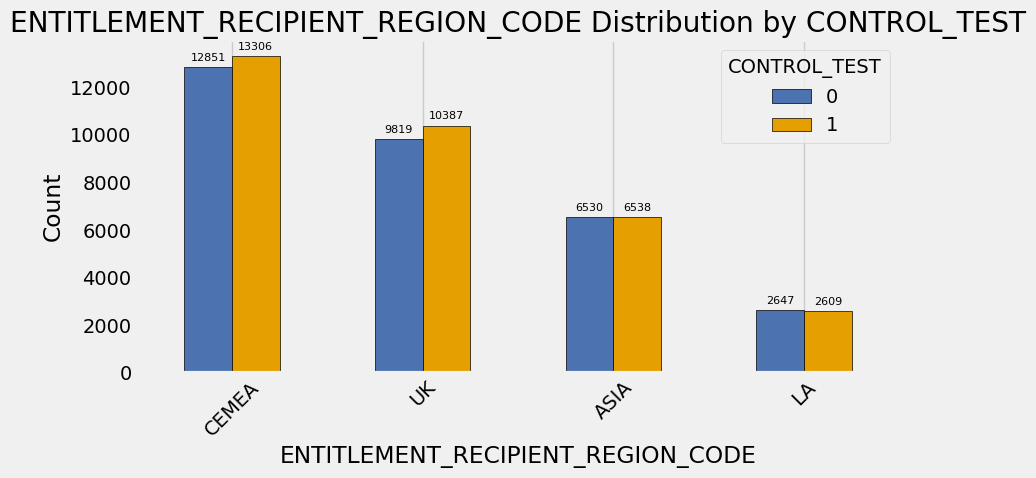

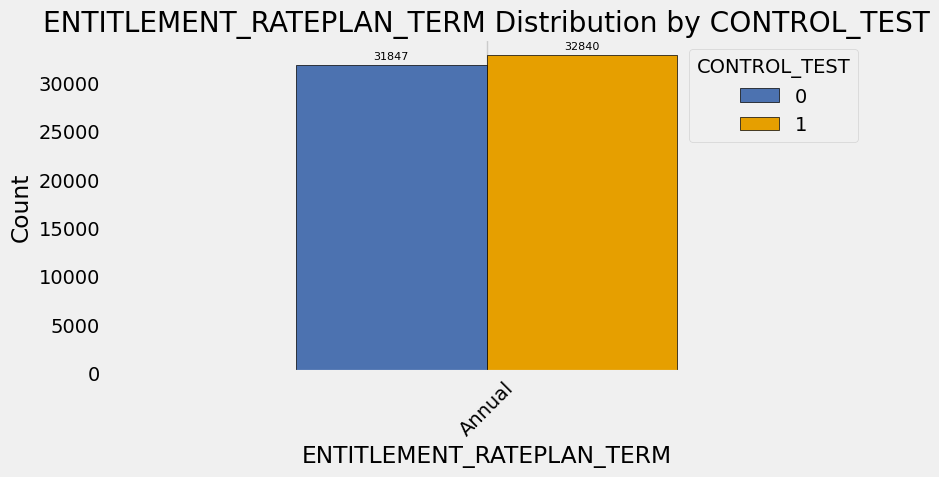

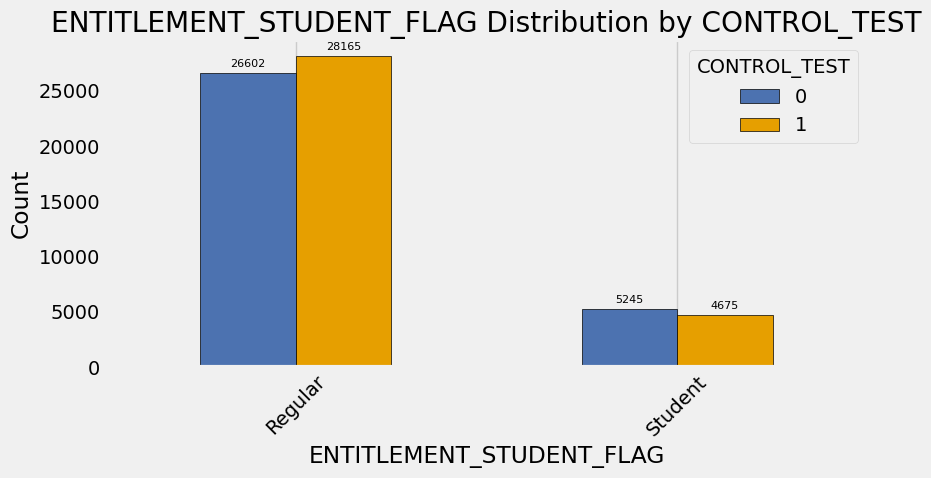

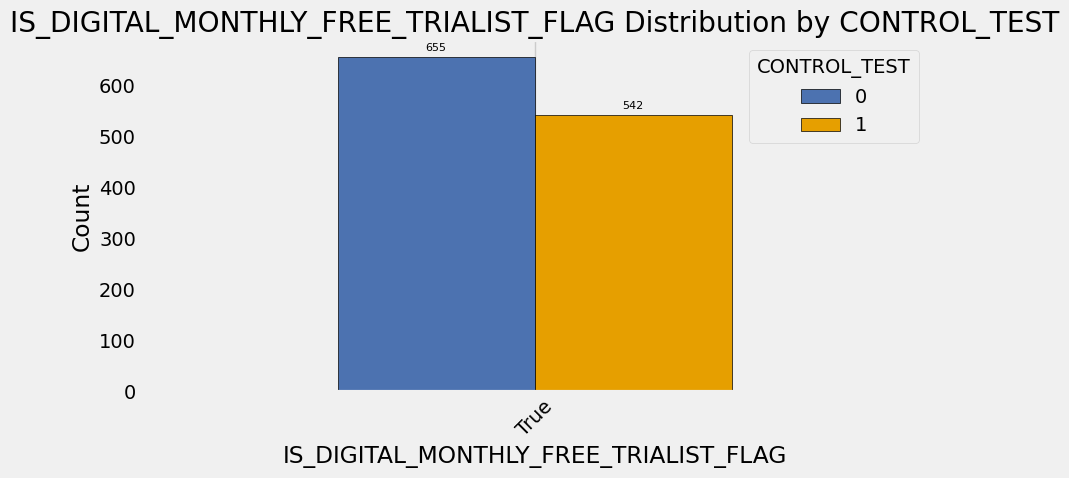

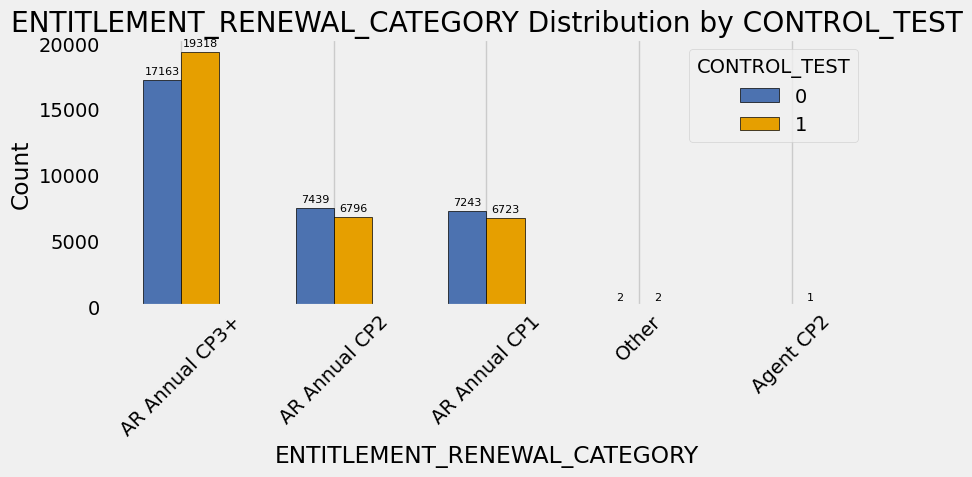

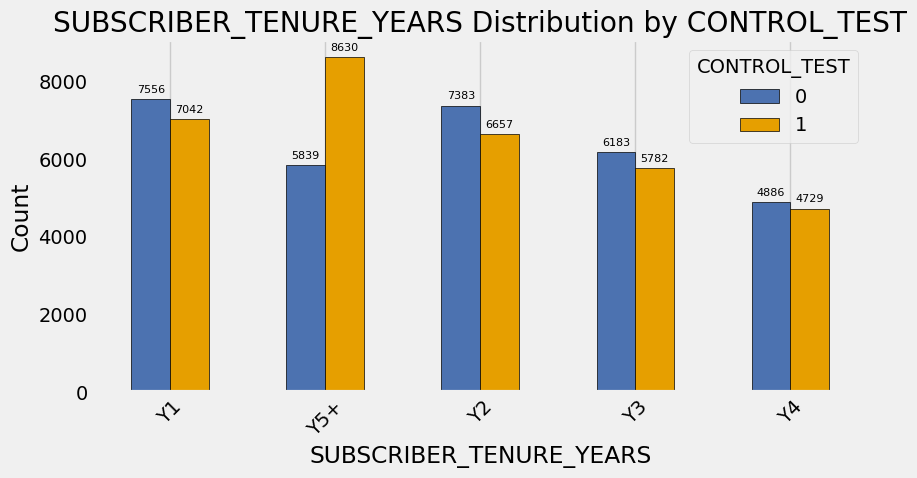

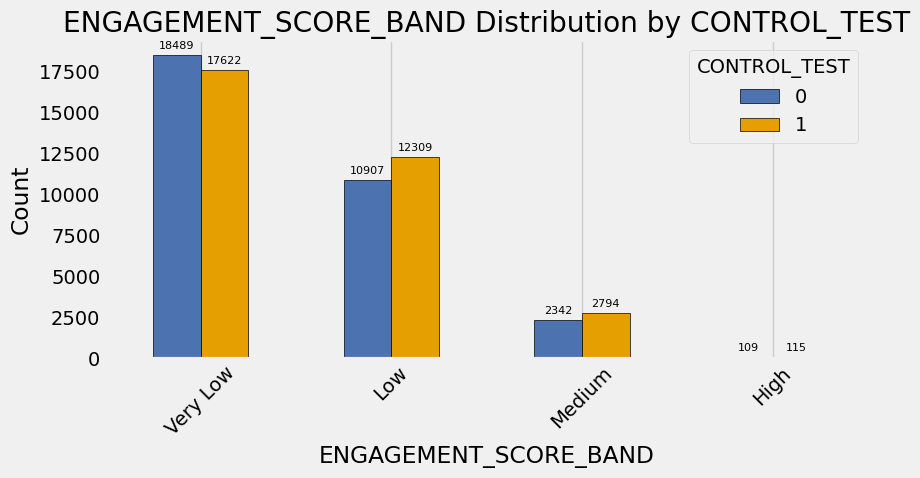

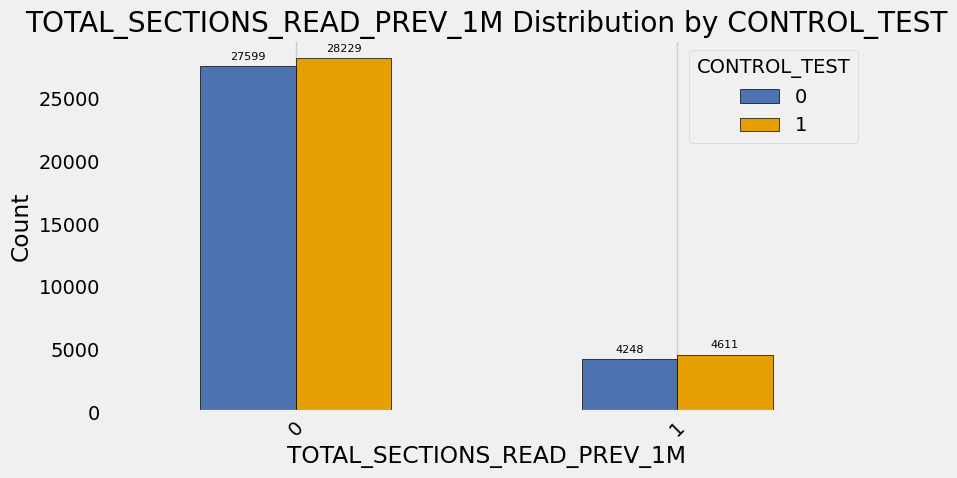

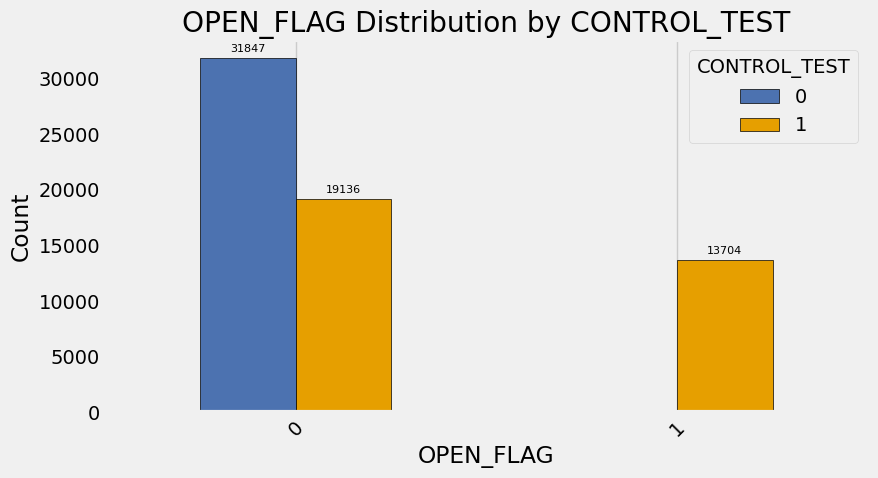

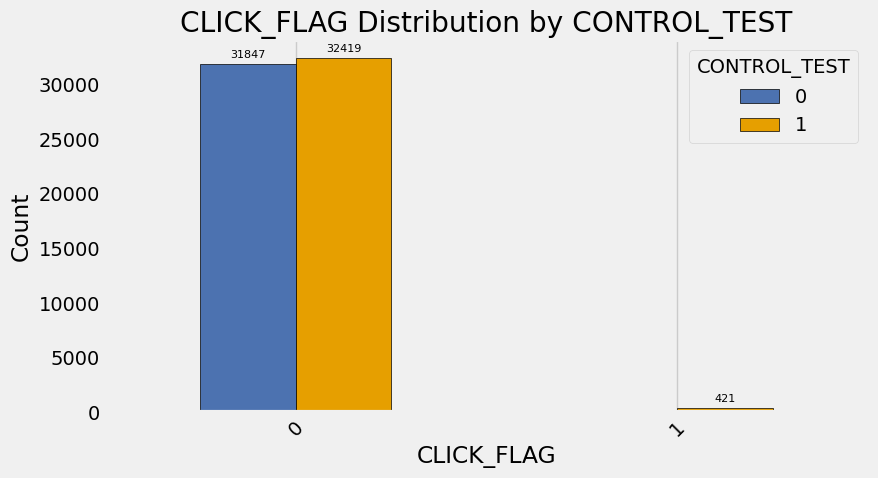

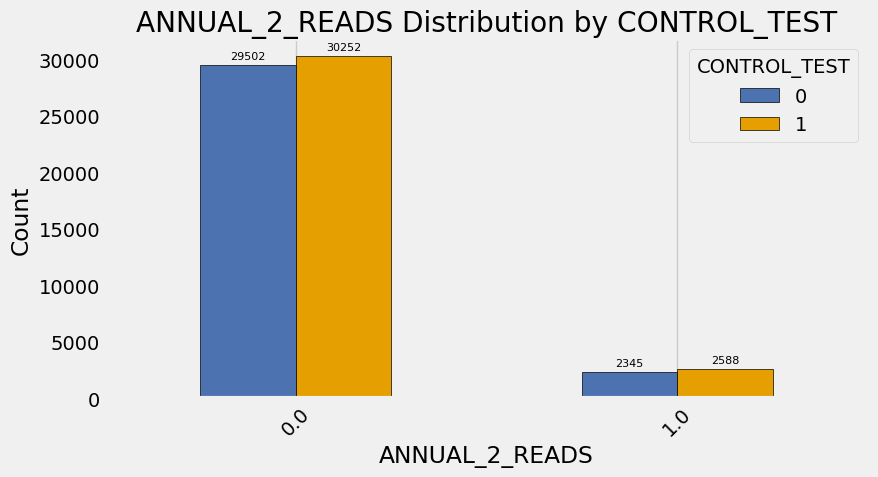

In [11]:
#Define funtion to plot bar graph
def plot_category_distribution_by_group(df, group_col='CONTROL_TEST', max_unique=20):
    """
    Plots grouped bar charts with value labels showing the count of each category or numeric group,
    split by a grouping column (e.g., Control vs. Test).
    """
    # Include both object-type and low-cardinality numeric columns (excluding the group_col)
    candidate_cols = [
        col for col in df.columns
        if col != group_col and df[col].nunique() <= max_unique
    ]

    for col in candidate_cols:
        # Drop rows with missing values in the column of interest
        counts = df[[col, group_col]].dropna().groupby([col, group_col]).size().unstack(fill_value=0)
        counts = counts.loc[counts.sum(axis=1).sort_values(ascending=False).index]
        custom_colors = ['#4C72B0', '#E69F00']

        ax = counts.plot(kind='bar', figsize=(9, 5), edgecolor='black', color=custom_colors[:counts.shape[1]])

        plt.title(f'{col} Distribution by {group_col}')
        plt.xlabel(col)
        plt.ylabel('Count')
        plt.xticks(rotation=45)
        plt.legend(title=group_col)
        plt.grid(axis='y')
        plt.tight_layout()

        # Add value labels on top of each bar
        for container in ax.containers:
            for bar in container:
                height = bar.get_height()
                if height > 0:
                    ax.annotate(f'{int(height)}',
                                xy=(bar.get_x() + bar.get_width() / 2, height),
                                xytext=(0, 3),
                                textcoords="offset points",
                                ha='center', va='bottom', fontsize=8)

        plt.show()

plot_category_distribution_by_group(df_filtered)


### Conversion Distribution

In [12]:
def plot_category_stacked_by_conversion_counts(df, category_col, group_col='CONTROL_TEST', outcome_col='ANNUAL_2_READS'):
    """
    Plots grouped (side-by-side) bars for each [Category x Group], stacked by conversion outcome (absolute count).
    """
    import pandas as pd
    import matplotlib.pyplot as plt
    import numpy as np

    # Filter and clean
    df_plot = df[[category_col, group_col, outcome_col]].dropna()

    # Group and count occurrences
    grouped = df_plot.groupby([category_col, group_col, outcome_col]).size().unstack(fill_value=0)

    # Create readable index: e.g. 'Asia - Control'
    grouped.index = grouped.index.map(lambda x: f"{x[0]} - {'Control' if x[1] == 0 else 'Treated'}")

    # Sort index alphabetically or by count if preferred
    grouped = grouped.sort_index()

    # Plot
    ax = grouped.plot(kind='bar', stacked=True, figsize=(12, 6),
                      color=['#4C72B0', '#E69F00'],  edgecolor='black')

    plt.title(f'{category_col} Distribution by Group, Stacked by Conversion')
    plt.ylabel('Number of Users')
    plt.xlabel(f'{category_col} - Group')
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='Conversion', labels=['No', 'Yes'])
    plt.grid(axis='y', linestyle='--', alpha=0.7)
 

    # Annotate bar segments with raw counts
    for container in ax.containers:
        for bar in container:
            height = bar.get_height()
            if height > 0:
                ax.annotate(f'{int(height)}',
                            (bar.get_x() + bar.get_width()/2, bar.get_y() + height/2),
                            ha='center', va='center', fontsize=12, color='black')

    plt.tight_layout()
    plt.show()


In [13]:
def plot_all_categorical_stacked(df, group_col='CONTROL_TEST', outcome_col='ANNUAL_2_READS', max_unique=20):
    """
    Loops through all low-cardinality categorical columns and plots grouped stacked bars by conversion count.
    """
    for col in df.columns:
        if col in [group_col, outcome_col]:
            continue
        if df[col].nunique() <= max_unique:
            print(f"Plotting: {col}")
            plot_category_stacked_by_conversion_counts(df, category_col=col,
                                                       group_col=group_col,
                                                       outcome_col=outcome_col)


Plotting: ENTITLEMENT_RECIPIENT_REGION_CODE


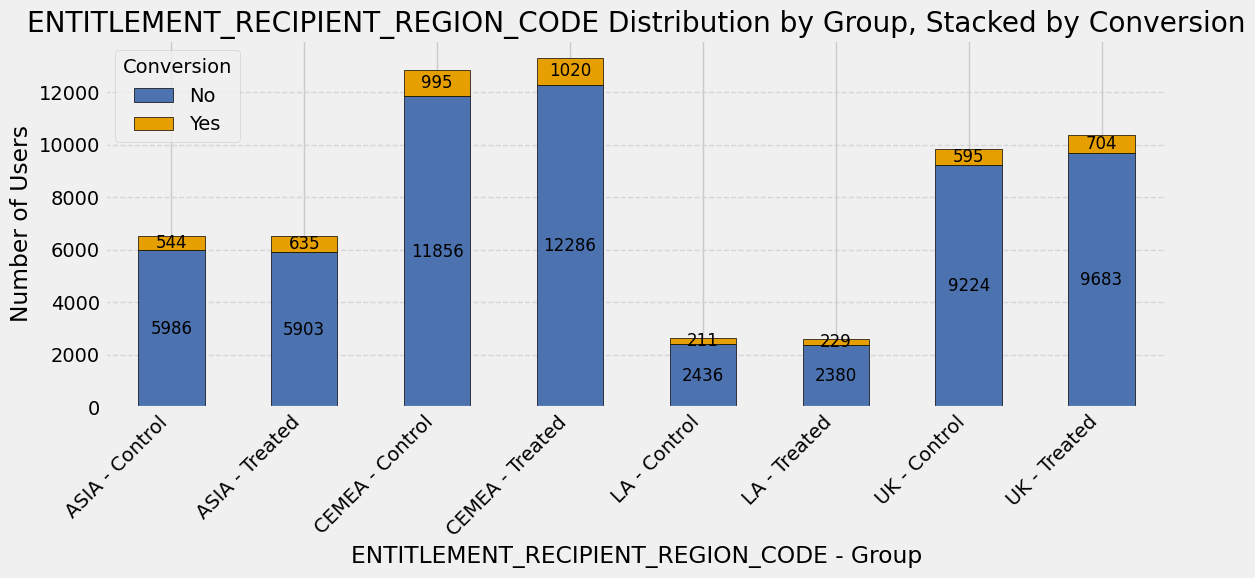

Plotting: ENTITLEMENT_RATEPLAN_TERM


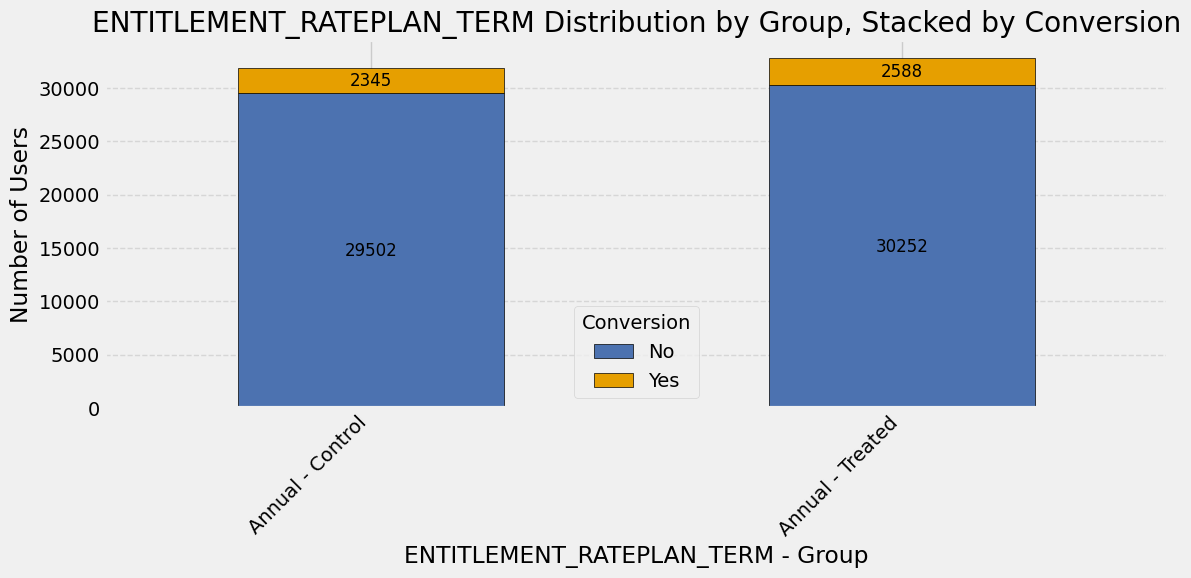

Plotting: ENTITLEMENT_STUDENT_FLAG


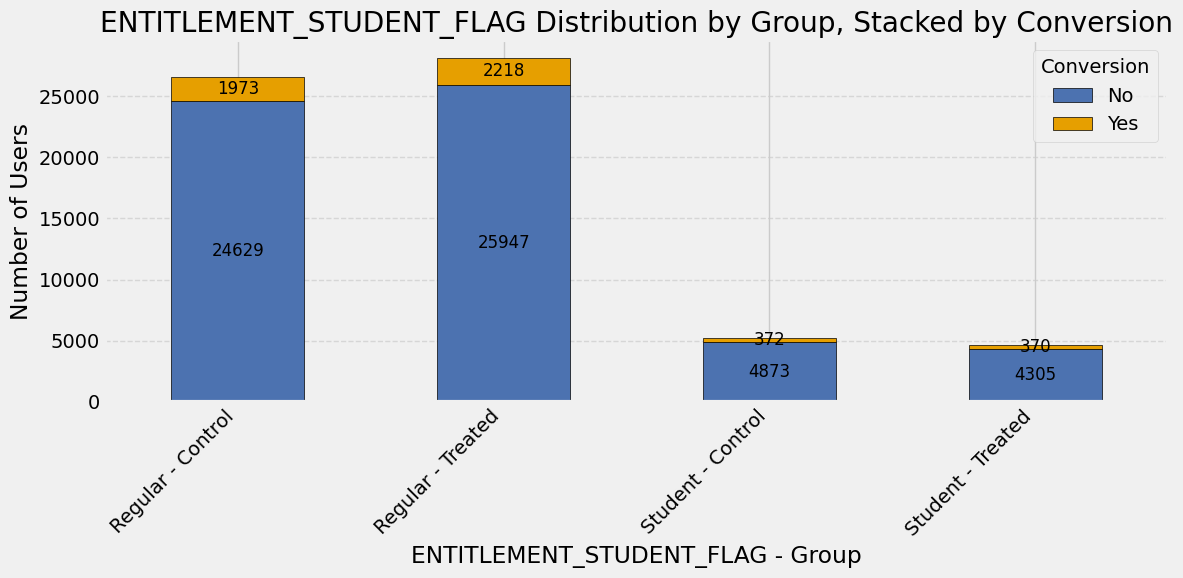

Plotting: IS_DIGITAL_MONTHLY_FREE_TRIALIST_FLAG


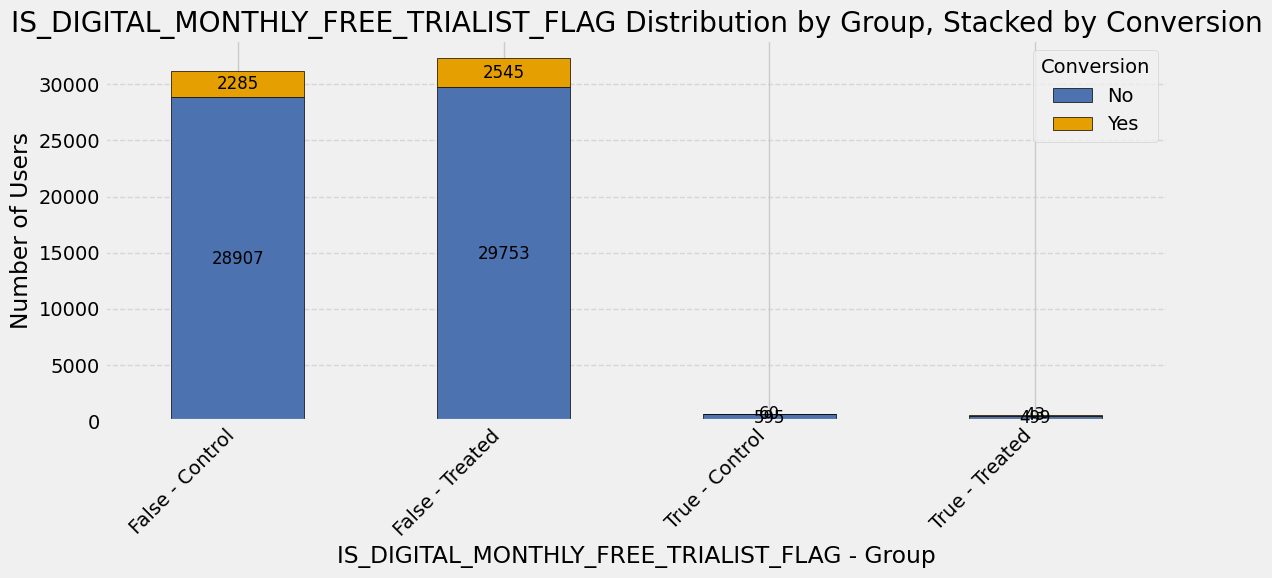

Plotting: ENTITLEMENT_RENEWAL_CATEGORY


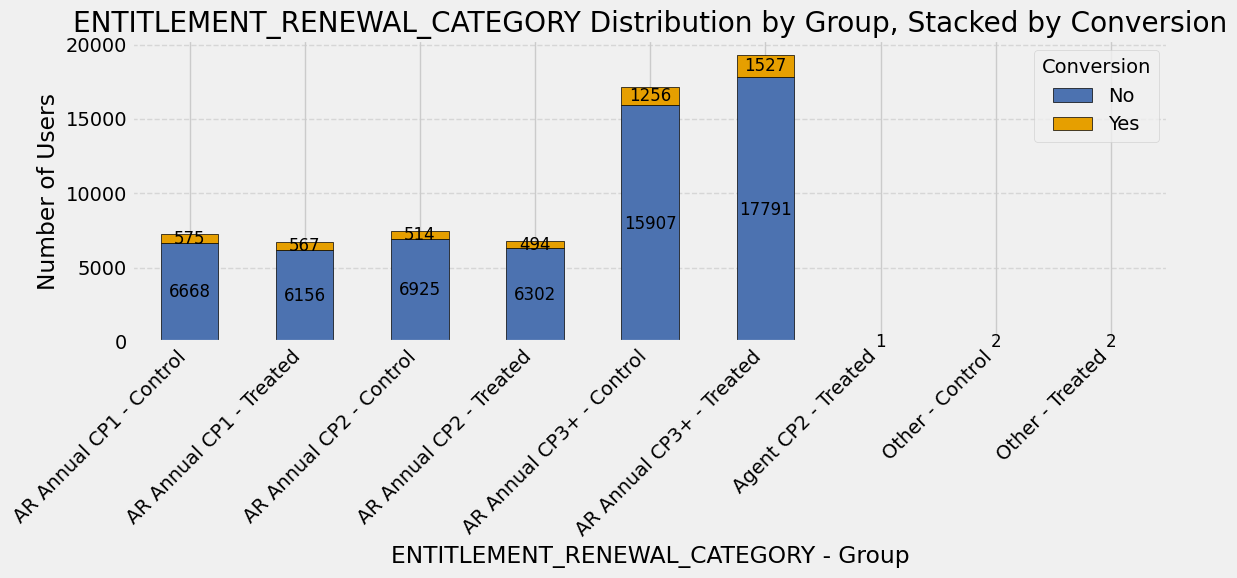

Plotting: SUBSCRIBER_TENURE_YEARS


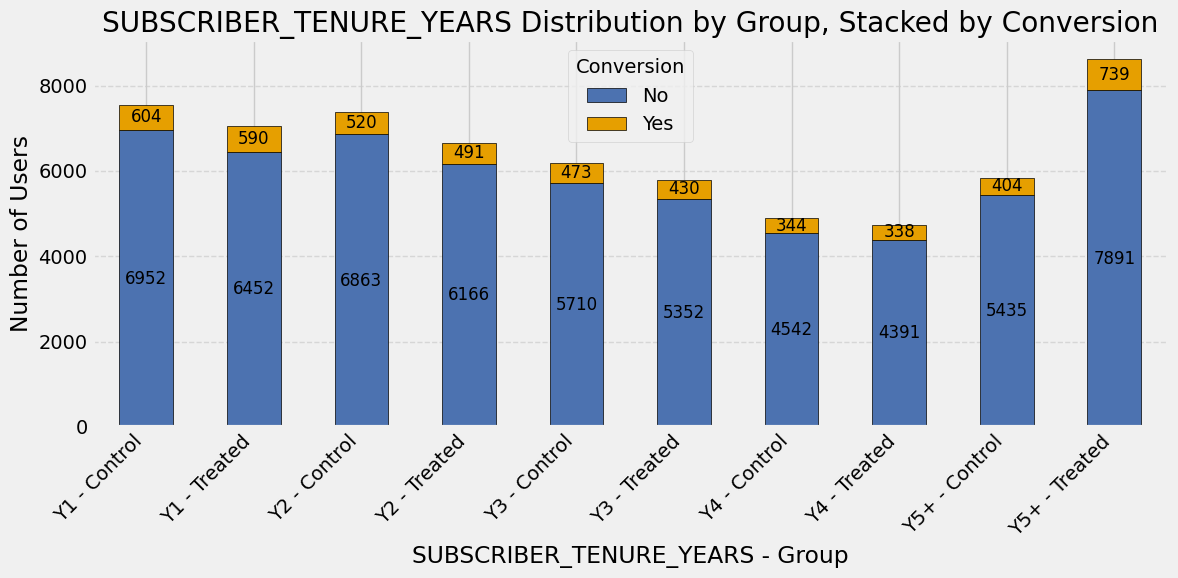

Plotting: ENGAGEMENT_SCORE_BAND


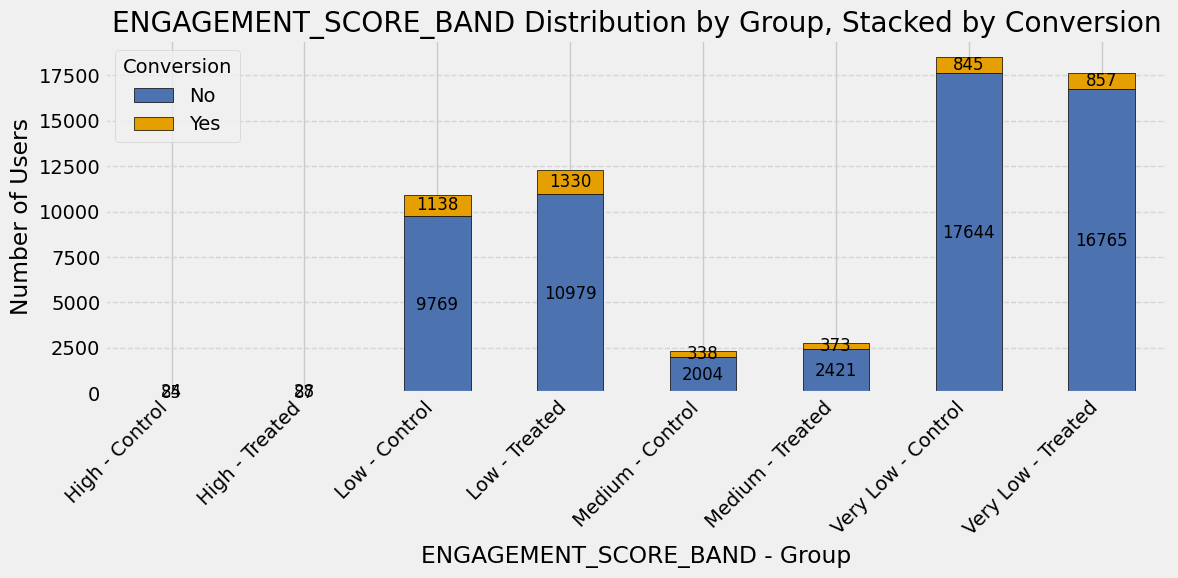

Plotting: TOTAL_SECTIONS_READ_PREV_1M


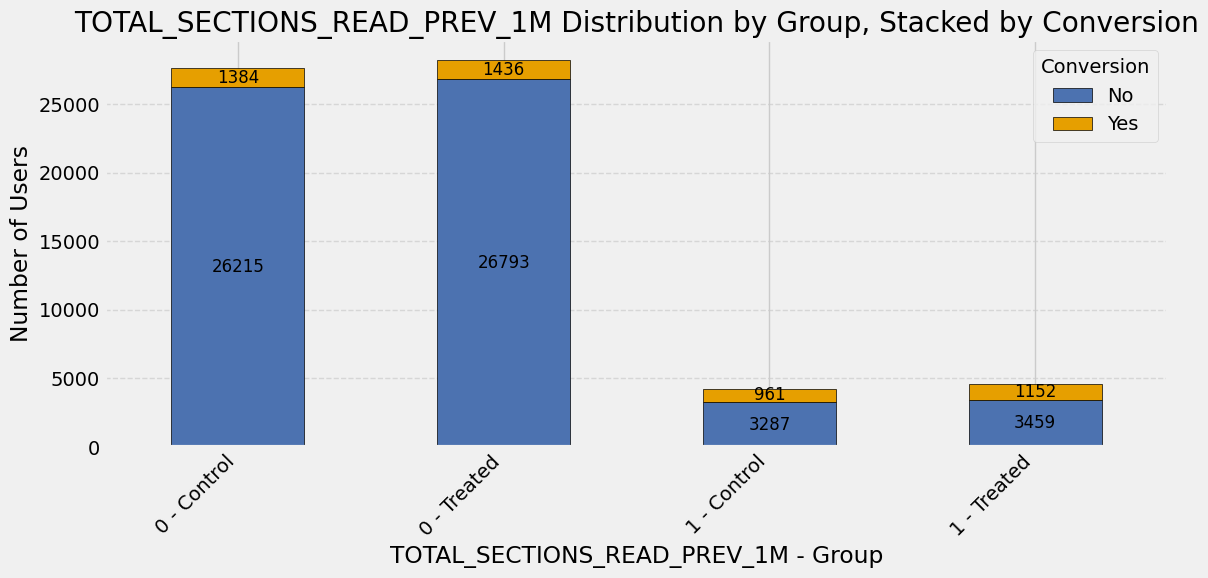

Plotting: OPEN_FLAG


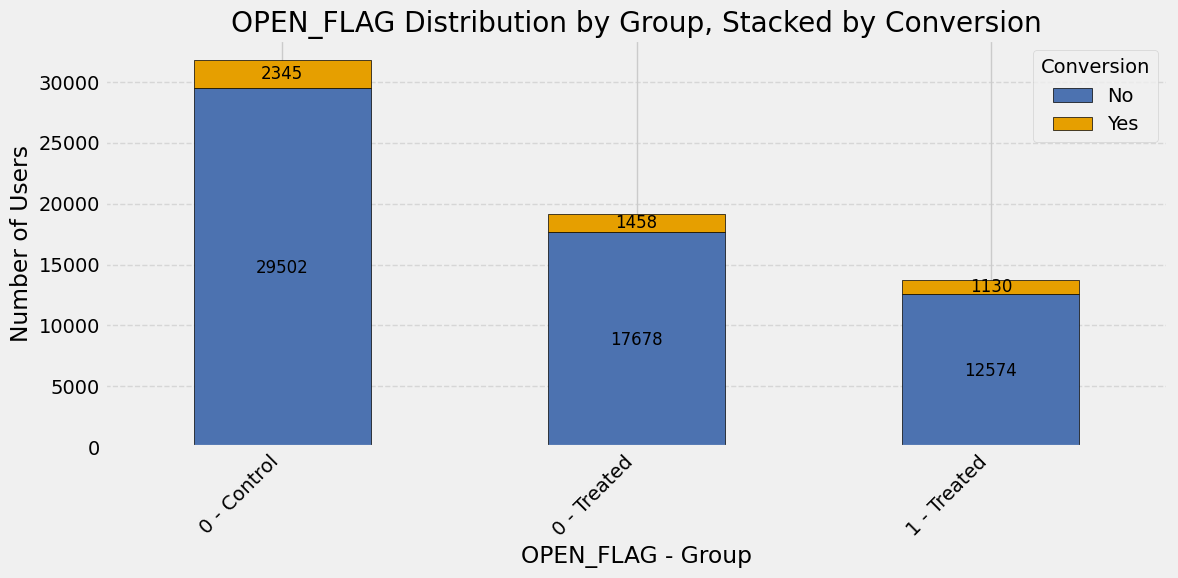

Plotting: CLICK_FLAG


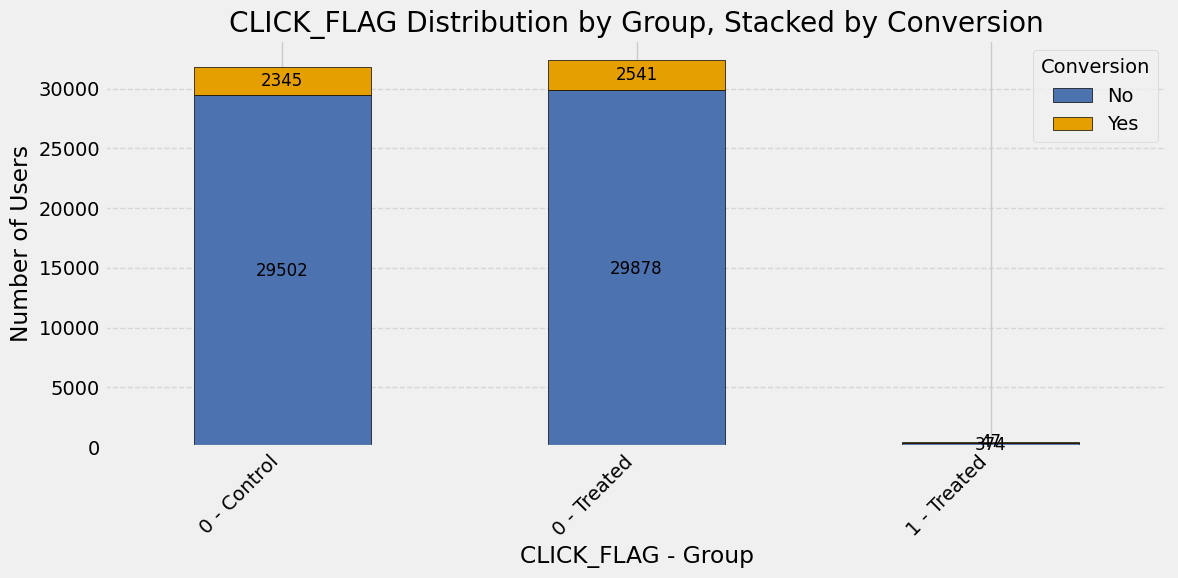

In [14]:
plot_all_categorical_stacked(df_filtered)


In [15]:
df_filtered

,ENTITLEMENT_KEY,CONTROL_TEST,ENTITLEMENT_RECIPIENT_REGION_CODE,ENTITLEMENT_RATEPLAN_TERM,ENTITLEMENT_STUDENT_FLAG,IS_DIGITAL_MONTHLY_FREE_TRIALIST_FLAG,ENTITLEMENT_RENEWAL_CATEGORY,SUBSCRIBER_TENURE_YEARS,ENGAGEMENT_SCORE_BAND,TOTAL_SECTIONS_READ_PREV_1M,OPEN_FLAG,CLICK_FLAG,TOTAL_SECTIONS_READ_FWD_2W,ANNUAL_2_READS
0,1.799330e+19,1,ASIA,Annual,Regular,False,AR Annual CP3+,Y4,Low,1,0,0,0,0.0
1,3.880818e+18,0,CEMEA,Annual,Student,False,AR Annual CP1,Y1,Medium,0,0,0,1,0.0
2,9.539141e+18,0,ASIA,Annual,Regular,False,AR Annual CP3+,Y5+,Very Low,0,0,0,0,0.0
3,3.901115e+18,1,UK,Annual,Regular,False,AR Annual CP3+,Y5+,Very Low,0,0,0,0,0.0
4,6.264435e+18,1,ASIA,Annual,Regular,False,AR Annual CP3+,Y5+,Very Low,0,0,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64683,1.058322e+19,0,ASIA,Annual,Regular,False,AR Annual CP1,Y1,Low,1,0,0,0,0.0
64684,8.903565e+18,0,CEMEA,Annual,Regular,False,AR Annual CP2,Y2,Low,0,0,0,2,1.0
64685,4.150208e+18,1,CEMEA,Annual,Regular,False,AR Annual CP3+,Y5+,Low,0,1,0,0,0.0
64686,1.061301e+19,0,CEMEA,Annual,Regular,False,AR Annual CP1,Y1,Low,0,0,0,0,0.0


### Distribution of Sections Read Binned

In [16]:
df_binned = df_filtered.copy()
df_binned.CONTROL_TEST.value_counts()

CONTROL_TEST
1    32840
0    31847
Name: count, dtype: int64

/tmp/ipykernel_9860/895567341.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df_binned.groupby(['READ_BIN', 'CONTROL_TEST']).size().unstack(fill_value=0).reindex(labels)


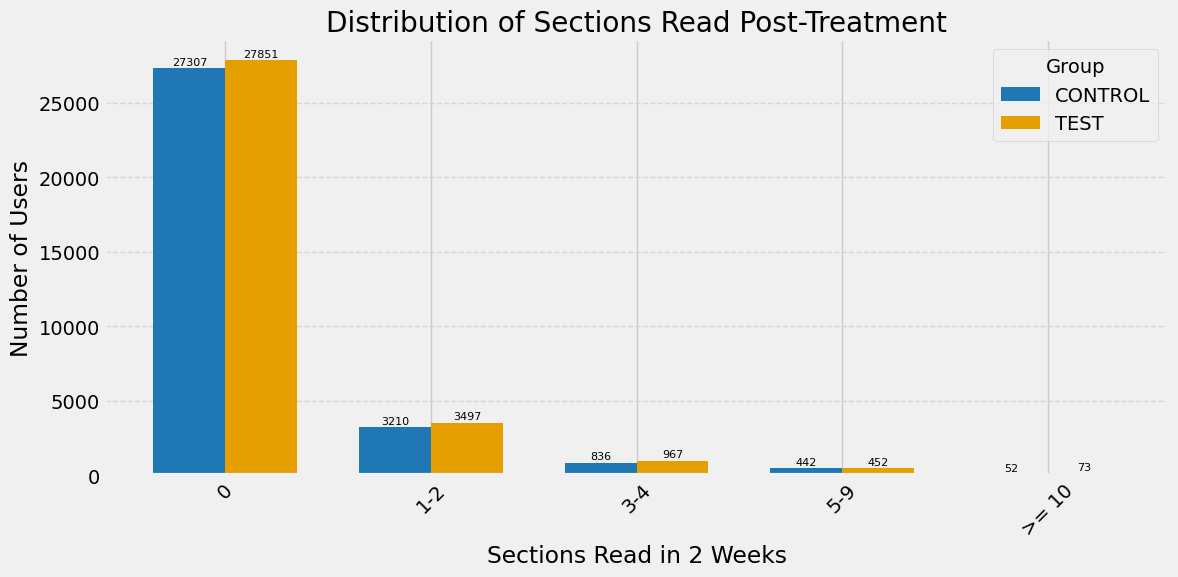

In [17]:
#Section Reads Post Treatment Distribution Barchart
max_val = df_binned.TOTAL_SECTIONS_READ_FWD_2W.max()
if max_val <= 5000:
    max_val = 5001

# Define bins and labels
bins = [0, 1, 3, 5, 10, max_val]
labels = ['0', '1-2', '3-4', '5-9', '>= 10']

# Create binned column
df_binned['READ_BIN'] = pd.cut(df_binned.TOTAL_SECTIONS_READ_FWD_2W, bins=bins, labels=labels, right=False)

# Group by READ_BIN and CONTROL_TEST (0 = CONTROL, 1 = TEST)
grouped = df_binned.groupby(['READ_BIN', 'CONTROL_TEST']).size().unstack(fill_value=0).reindex(labels)

# Set x positions
x = np.arange(len(labels))
width = 0.35

# Plot
plt.figure(figsize=(12, 6))
bar_control = plt.bar(x - width/2, grouped[0], width, label='CONTROL', color='#1f77b4')
bar_test = plt.bar(x + width/2, grouped[1], width, label='TEST', color='#E69F00')

# Add data labels
for bars in [bar_control, bar_test]:
    for bar in bars:
        yval = bar.get_height()
        if yval > 0:
            plt.text(bar.get_x() + bar.get_width()/2, yval + 100, str(yval), ha='center', va='bottom', fontsize=8)

# Labels and formatting
plt.xlabel('Sections Read in 2 Weeks')
plt.ylabel('Number of Users')
plt.title('Distribution of Sections Read Post-Treatment')
plt.xticks(x, labels, rotation=45)
plt.legend(title='Group')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


## Causal Inference Modelling: ATE Estimation

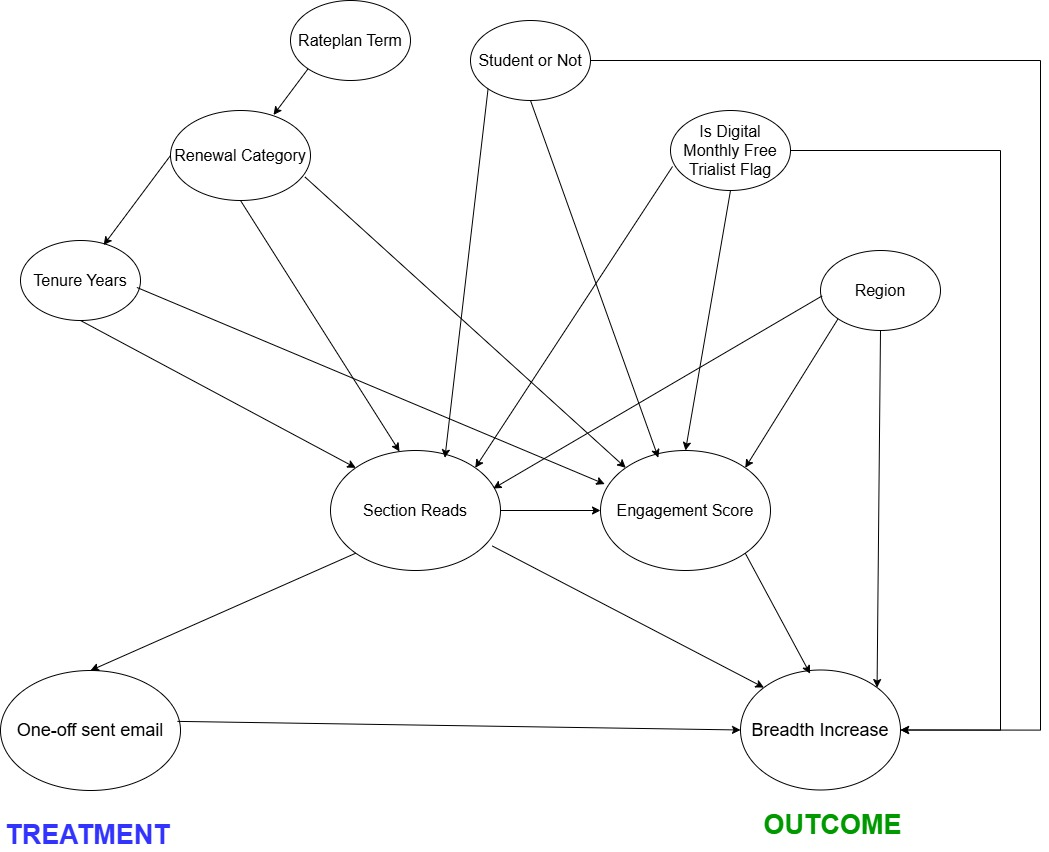

In [18]:
from IPython.display import Image

Image(filename='DAG_breadth_abtest.drawio.jpg')


### DoubleML: Without Confounders

In [19]:
# Minimal X: one constant dummy column to simulate no confounder exist
X = pd.DataFrame({'dummy': 1}, index=df_filtered.index)

# Define treatment and outcome
y = df_filtered['ANNUAL_2_READS']
d = df_filtered['CONTROL_TEST']

# Create DoubleMLData
dml_data = DoubleMLData.from_arrays(X, y=y, d=d)

# Define ML models
ml_g = RandomForestRegressor(n_estimators=100, random_state=42)
ml_m = RandomForestClassifier(n_estimators=100, random_state=42)

# Run DoubleML
dml = DoubleMLPLR(
    dml_data,
    ml_g=ml_g,    # model for E[Y|X]
    ml_m=ml_m,    # model for E[D|X]
    ml_l=ml_g,    
    n_folds=5
)

dml.fit()


# Get the summary from the fitted DoubleML object
summary_df_doubleml_noconfounders = dml.summary.reset_index()

# Rename columns for clarity
summary_df_doubleml_noconfounders.columns = ['Parameter', 'Coefficient', 'Std. Error', 't-stat', 'P-value', 'CI Lower (2.5%)', 'CI Upper (97.5%)']

# Rounding
summary_df_doubleml_noconfounders = summary_df_doubleml_noconfounders.round(4)

# Display the clean summary table
print(summary_df_doubleml_noconfounders.to_string(index=False))


/home/sagemaker-user/ucl_project/.venv/lib/python3.12/site-packages/doubleml/plm/plr.py:121: UserWarning: A learner ml_g has been provided for score = "partialling out" but will be ignored. "A learner ml_g is not required for estimation.
  warnings.warn(('A learner ml_g has been provided for score = "partialling out" but will be ignored. "'


Parameter  Coefficient  Std. Error  t-stat  P-value  CI Lower (2.5%)  CI Upper (97.5%)
        d       0.0052      0.0021  2.4798   0.0131           0.0011            0.0093


### DoubleML: With Confounders

In [20]:
# Minimal X: one constant dummy column to simulate no confounder exist
X = df_filtered['TOTAL_SECTIONS_READ_PREV_1M']

# Define treatment and outcome
y = df_filtered['TOTAL_SECTIONS_READ_FWD_2W']
d = df_filtered['CONTROL_TEST']

# Create DoubleMLData
dml_data = DoubleMLData.from_arrays(X, y=y, d=d)

# ML models
ml_g = RandomForestRegressor(n_estimators=100, random_state=42)
ml_m = RandomForestClassifier(n_estimators=100, random_state=42)

# Run DoubleML
dml = DoubleMLPLR(
    dml_data,
    ml_g=ml_g,    # model for E[Y|X]
    ml_m=ml_m,    # model for E[D|X]
    ml_l=ml_g,   
    n_folds=5
)

dml.fit()


# Get the summary from the fitted DoubleML object
summary_df_doubleml_noconfounders = dml.summary.reset_index()

# Rename columns for clarity
summary_df_doubleml_noconfounders.columns = ['Parameter', 'Coefficient', 'Std. Error', 't-stat', 'P-value', 'CI Lower (2.5%)', 'CI Upper (97.5%)']

# Rounding
summary_df_doubleml_noconfounders = summary_df_doubleml_noconfounders.round(4)

# Display the clean summary table
print(summary_df_doubleml_noconfounders.to_string(index=False))


/home/sagemaker-user/ucl_project/.venv/lib/python3.12/site-packages/doubleml/plm/plr.py:121: UserWarning: A learner ml_g has been provided for score = "partialling out" but will be ignored. "A learner ml_g is not required for estimation.
  warnings.warn(('A learner ml_g has been provided for score = "partialling out" but will be ignored. "'


Parameter  Coefficient  Std. Error  t-stat  P-value  CI Lower (2.5%)  CI Upper (97.5%)
        d        0.018      0.0085  2.1033   0.0354           0.0012            0.0347


### OLS: Without Confounders

In [21]:
# Define OLS Equation
result = smf.ols('ANNUAL_2_READS ~ CONTROL_TEST', data=df_filtered).fit()

# Display Summary
summary_df = result.summary2().tables[1]
summary_df['SIGNIFICANT'] = summary_df['P>|t|'] < 0.05
summary_df

,Coef.,Std.Err.,t,P>|t|,[0.025,0.975],SIGNIFICANT
Intercept,0.073633,0.001487,49.510858,0.000000,0.070718,0.076548,True
CONTROL_TEST,0.005173,0.002087,2.478356,0.013201,0.001082,0.009264,True


### OLS: With Confounders

In [22]:
# Define OLS Equation
result = smf.ols('TOTAL_SECTIONS_READ_FWD_2W ~ CONTROL_TEST + TOTAL_SECTIONS_READ_PREV_1M', data=df_filtered).fit()

# Display Summary
summary_df = result.summary2().tables[1]
summary_df['SIGNIFICANT'] = summary_df['P>|t|'] < 0.05
summary_df

,Coef.,Std.Err.,t,P>|t|,[0.025,0.975],SIGNIFICANT
Intercept,0.220248,0.006309,34.907869,1.649964e-264,0.207881,0.232614,True
CONTROL_TEST,0.018031,0.008545,2.110244,3.484121e-02,0.001284,0.034779,True
TOTAL_SECTIONS_READ_PREV_1M,0.796555,0.012425,64.107164,0.000000e+00,0.772201,0.820909,True


### OLS Confounder Correction Calculation

In [23]:
# Mean prior reads in each group
mean_treat = df_filtered[df_filtered['CONTROL_TEST'] == 1]['TOTAL_SECTIONS_READ_PREV_1M'].mean()
mean_control = df_filtered[df_filtered['CONTROL_TEST'] == 0]['TOTAL_SECTIONS_READ_PREV_1M'].mean()

# Imbalance
imbalance = mean_treat - mean_control

# Confounder coefficient (from regression)
confounder_coef = 0.7353

# Bias correction
bias_due_to_confounder = imbalance * confounder_coef

# Print it
print(f"Estimated bias correction: {bias_due_to_confounder:.4f}")


Estimated bias correction: 0.0052


## Causal Inference Modelling: HTE Estimation

### Region HTE

In [24]:
# Define OLS Equation
result = smf.ols('TOTAL_SECTIONS_READ_FWD_2W ~ CONTROL_TEST * C(ENTITLEMENT_RECIPIENT_REGION_CODE)', data=df_filtered).fit()

# Display Summary
summary_df = result.summary2().tables[1]
summary_df['SIGNIFICANT'] = summary_df['P>|t|'] < 0.05
summary_df

,Coef.,Std.Err.,t,P>|t|,[0.025,0.975],SIGNIFICANT
Intercept,0.367534,0.013854,26.528319,3.073415e-154,0.340380,0.394689,True
C(ENTITLEMENT_RECIPIENT_REGION_CODE)[T.CEMEA],-0.023437,0.017014,-1.377491,1.683651e-01,-0.056784,0.009911,False
C(ENTITLEMENT_RECIPIENT_REGION_CODE)[T.LA],-0.014682,0.025797,-0.569152,5.692547e-01,-0.065243,0.035879,False
C(ENTITLEMENT_RECIPIENT_REGION_CODE)[T.UK],-0.098464,0.017877,-5.507804,3.647173e-08,-0.133504,-0.063425,True
CONTROL_TEST,0.069296,0.019587,3.537856,4.036730e-04,0.030906,0.107687,True
CONTROL_TEST:C(ENTITLEMENT_RECIPIENT_REGION_CODE)[T.CEMEA],-0.071593,0.023987,-2.984649,2.840097e-03,-0.118608,-0.024578,True
CONTROL_TEST:C(ENTITLEMENT_RECIPIENT_REGION_CODE)[T.LA],-0.043076,0.036573,-1.177814,2.388751e-01,-0.114759,0.028607,False
CONTROL_TEST:C(ENTITLEMENT_RECIPIENT_REGION_CODE)[T.UK],-0.039435,0.025139,-1.568678,1.167279e-01,-0.088708,0.009838,False


In [25]:
# Run the model
model = smf.ols(
    'TOTAL_SECTIONS_READ_FWD_2W ~ CONTROL_TEST * C(ENTITLEMENT_RECIPIENT_REGION_CODE)',
    data=df_filtered
)
result = model.fit()

# Extract coefficients
coefs = result.params

# Get main treatment effect (baseline region, likely ASIA)
main_effect = coefs['CONTROL_TEST']

# Find all interaction terms
interaction_terms = {k: v for k, v in coefs.items() if 'CONTROL_TEST:C(ENTITLEMENT_RECIPIENT_REGION_CODE)' in k}

# Initialize dictionary of treatment effects per region
region_effects = {}

# Add baseline (ASIA) effect
region_effects['ASIA (baseline)'] = main_effect

# Add effects for all other regions
for term, value in interaction_terms.items():
    region = term.split('T.')[-1].strip(']')
    region_effects[region] = main_effect + value

# Turn into Datagrame
import pandas as pd
region_effects_df = pd.DataFrame([
    {'Region': k, 'Estimated_Treatment_Effect': round(v, 4)}
    for k, v in region_effects.items()
])

# Display result
region_effects_df


,Region,Estimated_Treatment_Effect
0,ASIA (baseline),0.0693
1,CEMEA,-0.0023
2,LA,0.0262
3,UK,0.0299


### Student Flag HTE

In [26]:
# Define OLS Equation
result = smf.ols('TOTAL_SECTIONS_READ_FWD_2W ~ CONTROL_TEST * C(ENTITLEMENT_STUDENT_FLAG)', data=df_filtered).fit()

# Display Summary
summary_df = result.summary2().tables[1]
summary_df['SIGNIFICANT'] = summary_df['P>|t|'] < 0.05
summary_df

,Coef.,Std.Err.,t,P>|t|,[0.025,0.975],SIGNIFICANT
Intercept,0.327607,0.006869,47.690847,0.000000,0.314143,0.341071,True
C(ENTITLEMENT_STUDENT_FLAG)[T.Student],-0.006730,0.016927,-0.397585,0.690937,-0.039907,0.026447,False
CONTROL_TEST,0.021976,0.009579,2.294158,0.021785,0.003201,0.040751,True
CONTROL_TEST:C(ENTITLEMENT_STUDENT_FLAG)[T.Student],0.010516,0.024487,0.429458,0.667591,-0.037478,0.058510,False


In [27]:
# Run the model
model = smf.ols(
    'TOTAL_SECTIONS_READ_FWD_2W ~ CONTROL_TEST * C(ENTITLEMENT_STUDENT_FLAG)',
    data=df_filtered
)
result = model.fit()

# Extract coefficients
coefs = result.params

# Get main treatment effect (baseline group, e.g., non-student)
main_effect = coefs['CONTROL_TEST']

# Find all interaction terms for student status
interaction_terms = {
    k: v for k, v in coefs.items() if 'CONTROL_TEST:C(ENTITLEMENT_STUDENT_FLAG)' in k
}

# Initialize dictionary of treatment effects per student type
effects_by_student_flag = {}

# Add baseline (non-student or whatever the base level is)
effects_by_student_flag['Non-Student (baseline)'] = main_effect

# Add effects for other categories (likely just one: True or False)
for term, value in interaction_terms.items():
    group = term.split('T.')[-1].strip(']')
    effects_by_student_flag[group] = main_effect + value

# Convert to DataFrame
student_effects_df = pd.DataFrame([
    {'Student_Status': k, 'Estimated_Treatment_Effect': round(v, 4)}
    for k, v in effects_by_student_flag.items()
])

# Display result
student_effects_df


,Student_Status,Estimated_Treatment_Effect
0,Non-Student (baseline),0.0220
1,Student,0.0325


### Monthly Trialist HTE

In [28]:
# Define OLS Equation
result = smf.ols('TOTAL_SECTIONS_READ_FWD_2W ~ CONTROL_TEST * C(IS_DIGITAL_MONTHLY_FREE_TRIALIST_FLAG)', data=df_filtered).fit()

# Display Summary
summary_df = result.summary2().tables[1]
summary_df['SIGNIFICANT'] = summary_df['P>|t|'] < 0.05
summary_df

,Coef.,Std.Err.,t,P>|t|,[0.025,0.975],SIGNIFICANT
Intercept,0.323897,0.006343,51.059950,0.000000,0.311464,0.336330,True
C(IS_DIGITAL_MONTHLY_FREE_TRIALIST_FLAG)[T.True],0.126485,0.044232,2.859546,0.004244,0.039789,0.213180,True
CONTROL_TEST,0.026094,0.008894,2.933876,0.003349,0.008662,0.043526,True
CONTROL_TEST:C(IS_DIGITAL_MONTHLY_FREE_TRIALIST_FLAG)[T.True],-0.118542,0.065659,-1.805405,0.071016,-0.247234,0.010151,False


In [29]:
# Run the model with interaction
model = smf.ols(
    'TOTAL_SECTIONS_READ_FWD_2W ~ CONTROL_TEST * C(IS_DIGITAL_MONTHLY_FREE_TRIALIST_FLAG)',
    data=df_filtered
)
result = model.fit()

# Extract coefficients
coefs = result.params

# Main treatment effect for the baseline group (e.g., non-trialists)
main_effect = coefs['CONTROL_TEST']

# Extract interaction terms
interaction_terms = {
    k: v for k, v in coefs.items() if 'CONTROL_TEST:C(IS_DIGITAL_MONTHLY_FREE_TRIALIST_FLAG)' in k
}

# Prepare treatment effect dictionary
effects_by_trialist_flag = {}
effects_by_trialist_flag['Non-Trialist (baseline)'] = main_effect

# Add effects for trialists
for term, value in interaction_terms.items():
    group = term.split('T.')[-1].strip(']')
    effects_by_trialist_flag[group] = main_effect + value

# Format as DataFrame
trialist_effects_df = pd.DataFrame([
    {'Trialist_Status': k, 'Estimated_Treatment_Effect': round(v, 4)}
    for k, v in effects_by_trialist_flag.items()
])

# Display result
trialist_effects_df


,Trialist_Status,Estimated_Treatment_Effect
0,Non-Trialist (baseline),0.0261
1,True,-0.0924


### Renewal Category HTE

In [30]:
# Define OLS Equation
result = smf.ols('TOTAL_SECTIONS_READ_FWD_2W ~ CONTROL_TEST * C(ENTITLEMENT_RENEWAL_CATEGORY)', data=df_filtered).fit()

# Display Summary
summary_df = result.summary2().tables[1]
summary_df['SIGNIFICANT'] = summary_df['P>|t|'] < 0.05
summary_df

,Coef.,Std.Err.,t,P>|t|,[0.025,0.975],SIGNIFICANT
Intercept,0.350960,0.013164,26.660092,9.550574e-156,0.325158,0.376761,True
C(ENTITLEMENT_RENEWAL_CATEGORY)[T.AR Annual CP2],-0.048231,0.018494,-2.607911,9.111768e-03,-0.084479,-0.011982,True
C(ENTITLEMENT_RENEWAL_CATEGORY)[T.AR Annual CP3+],-0.024501,0.015698,-1.560792,1.185778e-01,-0.055270,0.006267,False
C(ENTITLEMENT_RENEWAL_CATEGORY)[T.Agent CP2],-0.185557,0.560218,-0.331223,7.404771e-01,-1.283584,0.912470,False
C(ENTITLEMENT_RENEWAL_CATEGORY)[T.Other],0.149040,0.792318,0.188107,8.507935e-01,-1.403904,1.701985,False
CONTROL_TEST,0.020155,0.018974,1.062241,2.881303e-01,-0.017034,0.057343,False
CONTROL_TEST:C(ENTITLEMENT_RENEWAL_CATEGORY)[T.AR Annual CP2],0.008929,0.026710,0.334310,7.381464e-01,-0.043422,0.061281,False
CONTROL_TEST:C(ENTITLEMENT_RENEWAL_CATEGORY)[T.AR Annual CP3+],0.002699,0.022318,0.120928,9.037485e-01,-0.041045,0.046443,False
CONTROL_TEST:C(ENTITLEMENT_RENEWAL_CATEGORY)[T.Agent CP2],-0.185557,0.560218,-0.331223,7.404771e-01,-1.283584,0.912470,False
CONTROL_TEST:C(ENTITLEMENT_RENEWAL_CATEGORY)[T.Other],-0.520155,1.120513,-0.464211,6.424981e-01,-2.716361,1.676052,False


In [31]:
# Fit OLS model with interaction
model = smf.ols(
    'TOTAL_SECTIONS_READ_FWD_2W ~ CONTROL_TEST * C(ENTITLEMENT_RENEWAL_CATEGORY)',
    data=df_filtered
)
result = model.fit()

# Extract coefficients
coefs = result.params

# Main treatment effect for the baseline category
main_effect = coefs['CONTROL_TEST']

# Extract interaction terms
interaction_terms = {
    k: v for k, v in coefs.items() if 'CONTROL_TEST:C(ENTITLEMENT_RENEWAL_CATEGORY)' in k
}

# Prepare dictionary to hold treatment effects
effects_by_renewal_category = {}
effects_by_renewal_category['AR Annual CP1'] = main_effect  # baseline group

# Add treatment effects for each subgroup by adding interaction term
for term, value in interaction_terms.items():
    group = term.split('T.')[-1].strip(']')
    effects_by_renewal_category[group] = main_effect + value

# Format into a DataFrame
renewal_effects_df = pd.DataFrame([
    {'Renewal_Category': k, 'Estimated_Treatment_Effect': round(v, 4)}
    for k, v in effects_by_renewal_category.items()
])

# Display results
renewal_effects_df


,Renewal_Category,Estimated_Treatment_Effect
0,AR Annual CP1,0.0202
1,AR Annual CP2,0.0291
2,AR Annual CP3+,0.0229
3,Agent CP2,-0.1654
4,Other,-0.5000


### Tenure Years HTE

In [32]:
# Define OLS Equation
result = smf.ols('TOTAL_SECTIONS_READ_FWD_2W ~ CONTROL_TEST * C(SUBSCRIBER_TENURE_YEARS) + TOTAL_SECTIONS_READ_PREV_1M', data=df_filtered).fit()

# Display Summary
summary_df = result.summary2().tables[1]
summary_df['SIGNIFICANT'] = summary_df['P>|t|'] < 0.05
summary_df

,Coef.,Std.Err.,t,P>|t|,[0.025,0.975],SIGNIFICANT
Intercept,0.248196,0.012612,19.680013,5.716785e-86,0.223477,0.272914,True
C(SUBSCRIBER_TENURE_YEARS)[T.Y2],-0.043067,0.017777,-2.422654,1.541031e-02,-0.077909,-0.008224,True
C(SUBSCRIBER_TENURE_YEARS)[T.Y3],-0.036338,0.018629,-1.950651,5.110286e-02,-0.072850,0.000174,False
C(SUBSCRIBER_TENURE_YEARS)[T.Y4],-0.036409,0.019942,-1.825702,6.789972e-02,-0.075496,0.002678,False
C(SUBSCRIBER_TENURE_YEARS)[T.Y5+],-0.028743,0.018928,-1.518526,1.288867e-01,-0.065841,0.008356,False
CONTROL_TEST,0.001625,0.017994,0.090329,9.280263e-01,-0.033642,0.036893,False
CONTROL_TEST:C(SUBSCRIBER_TENURE_YEARS)[T.Y2],0.017657,0.025707,0.686860,4.921735e-01,-0.032728,0.068042,False
CONTROL_TEST:C(SUBSCRIBER_TENURE_YEARS)[T.Y3],0.000105,0.026808,0.003919,9.968733e-01,-0.052440,0.052650,False
CONTROL_TEST:C(SUBSCRIBER_TENURE_YEARS)[T.Y4],-0.002297,0.028545,-0.080471,9.358632e-01,-0.058245,0.053651,False
CONTROL_TEST:C(SUBSCRIBER_TENURE_YEARS)[T.Y5+],0.050121,0.025741,1.947141,5.152212e-02,-0.000331,0.100572,False


In [33]:
# Run the model with interaction
model = smf.ols(
    'TOTAL_SECTIONS_READ_FWD_2W ~ CONTROL_TEST * C(SUBSCRIBER_TENURE_YEARS) + TOTAL_SECTIONS_READ_PREV_1M',
    data=df_filtered
)
result = model.fit()

# Extract coefficients
coefs = result.params

# Get baseline treatment effect (e.g., for first group like Y1)
main_effect = coefs['CONTROL_TEST']

# Get interaction terms for each tenure level
interaction_terms = {
    k: v for k, v in coefs.items() if 'CONTROL_TEST:C(SUBSCRIBER_TENURE_YEARS)' in k
}

# Build dictionary of treatment effects
tenure_effects = {}
tenure_effects['Baseline (e.g., Y1)'] = main_effect

for term, value in interaction_terms.items():
    group = term.split('T.')[-1].strip(']')
    tenure_effects[group] = main_effect + value

# Convert to DataFrame
tenure_effects_df = pd.DataFrame([
    {'Tenure_Group': k, 'Estimated_Treatment_Effect': round(v, 4)}
    for k, v in tenure_effects.items()
])

# Display result
tenure_effects_df


,Tenure_Group,Estimated_Treatment_Effect
0,"Baseline (e.g., Y1)",0.0016
1,Y2,0.0193
2,Y3,0.0017
3,Y4,-0.0007
4,Y5+,0.0517


### Engagement Score HTE

In [34]:
# Define OLS Equation
result = smf.ols('TOTAL_SECTIONS_READ_FWD_2W ~ CONTROL_TEST * C(ENGAGEMENT_SCORE_BAND)', data=df_filtered).fit()

# Display Summary
summary_df = result.summary2().tables[1]
summary_df['SIGNIFICANT'] = summary_df['P>|t|'] < 0.05
summary_df

,Coef.,Std.Err.,t,P>|t|,[0.025,0.975],SIGNIFICANT
Intercept,0.954128,0.106421,8.965636,3.164843e-19,0.745544,1.162713,True
C(ENGAGEMENT_SCORE_BAND)[T.Low],-0.488189,0.106951,-4.564604,5.013581e-06,-0.697813,-0.278565,True
C(ENGAGEMENT_SCORE_BAND)[T.Medium],-0.345674,0.108869,-3.175141,1.498342e-03,-0.559057,-0.132291,True
C(ENGAGEMENT_SCORE_BAND)[T.Very Low],-0.749304,0.106734,-7.020304,2.235582e-12,-0.958502,-0.540106,True
CONTROL_TEST,-0.075868,0.148525,-0.510805,6.094892e-01,-0.366978,0.215242,False
CONTROL_TEST:C(ENGAGEMENT_SCORE_BAND)[T.Low],0.082672,0.149242,0.553943,5.796196e-01,-0.209843,0.375187,False
CONTROL_TEST:C(ENGAGEMENT_SCORE_BAND)[T.Medium],0.045438,0.151752,0.299420,7.646208e-01,-0.251997,0.342872,False
CONTROL_TEST:C(ENGAGEMENT_SCORE_BAND)[T.Very Low],0.095932,0.148985,0.643905,5.196392e-01,-0.196079,0.387944,False


In [35]:
# Fit OLS model with interaction
model = smf.ols(
    'TOTAL_SECTIONS_READ_FWD_2W ~ CONTROL_TEST * C(ENGAGEMENT_SCORE_BAND)',
    data=df_filtered
)
result = model.fit()

# Extract coefficients
coefs = result.params

# Main treatment effect for the baseline engagement score band
main_effect = coefs['CONTROL_TEST']

# Extract interaction terms
interaction_terms = {
    k: v for k, v in coefs.items() if 'CONTROL_TEST:C(ENGAGEMENT_SCORE_BAND)' in k
}

# Prepare dictionary to hold treatment effects
effects_by_engagement_band = {}
effects_by_engagement_band['High'] = main_effect  # baseline category

# Compute treatment effect per engagement score band
for term, value in interaction_terms.items():
    group = term.split('T.')[-1].strip(']')
    effects_by_engagement_band[group] = main_effect + value

# Format into DataFrame
engagement_effects_df = pd.DataFrame([
    {'Engagement_Score_Band': k, 'Estimated_Treatment_Effect': round(v, 4)}
    for k, v in effects_by_engagement_band.items()
])

# Display the result
engagement_effects_df


,Engagement_Score_Band,Estimated_Treatment_Effect
0,High,-0.0759
1,Low,0.0068
2,Medium,-0.0304
3,Very Low,0.0201


### Section Reads Prior to Treatment HTE

In [36]:
# Define OLS Equation
result = smf.ols('TOTAL_SECTIONS_READ_FWD_2W ~ CONTROL_TEST * TOTAL_SECTIONS_READ_PREV_1M', data=df_filtered).fit()

#Display Summary
summary_df = result.summary2().tables[1]
summary_df['SIGNIFICANT'] = summary_df['P>|t|'] < 0.05
summary_df

,Coef.,Std.Err.,t,P>|t|,[0.025,0.975],SIGNIFICANT
Intercept,0.225407,0.006539,34.470202,4.966048e-258,0.212590,0.238224,True
CONTROL_TEST,0.007829,0.009196,0.851301,3.946052e-01,-0.010196,0.025853,False
TOTAL_SECTIONS_READ_PREV_1M,0.757880,0.017905,42.328721,0.000000e+00,0.722786,0.792973,True
CONTROL_TEST:TOTAL_SECTIONS_READ_PREV_1M,0.074598,0.024866,2.999964,2.701139e-03,0.025860,0.123335,True


In [37]:
# Fit the interaction model
result = smf.ols(
    'TOTAL_SECTIONS_READ_FWD_2W ~ CONTROL_TEST * TOTAL_SECTIONS_READ_PREV_1M',
    data=df_filtered
).fit()

# Extract coefficients
coefs = result.params

# Base effect of CONTROL_TEST (when prior engagement is zero)
baseline_effect = coefs['CONTROL_TEST']

# Marginal effect of prior engagement in control group
slope_control = coefs['TOTAL_SECTIONS_READ_PREV_1M']

# Interaction effect: difference in slope for test group
interaction = coefs['CONTROL_TEST:TOTAL_SECTIONS_READ_PREV_1M']

# Compute treatment effects across different prior engagement levels
engagement_levels = [0, 1]  # or use quantiles, means, etc.
treatment_effects = []

for level in engagement_levels:
    effect = baseline_effect + interaction * level
    treatment_effects.append({
        'Prev_Engagement_Level': level,
        'Estimated_Treatment_Effect': round(effect, 4)
    })

# Convert to DataFrame
treatment_effects_df = pd.DataFrame(treatment_effects)

# Display result
treatment_effects_df


,Prev_Engagement_Level,Estimated_Treatment_Effect
0,0,0.0078
1,1,0.0824


In [38]:
df_filtered.to_csv('df_causal_model.csv', index=False)

## Causal Inference Modelling: Mediator Effect

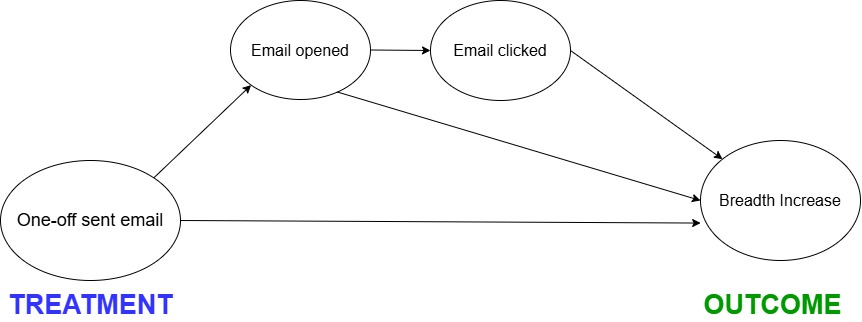

In [39]:
Image(filename='DAG_Mediator.jpg')

### Data Preparation

In [40]:
df = pd.read_csv('df_causal_model.csv')
df['ENTITLEMENT_RECIPIENT_REGION_CODE'] = df['ENTITLEMENT_RECIPIENT_REGION_CODE'].fillna('NA')
df['ENTITLEMENT_RECIPIENT_REGION_CODE'] = pd.Categorical(
    df['ENTITLEMENT_RECIPIENT_REGION_CODE'],
    categories=['ASIA', 'CEMEA', 'LA', 'NA', 'UK'],  # this MUST include all present values
    ordered=False
)

df

,ENTITLEMENT_KEY,CONTROL_TEST,ENTITLEMENT_RECIPIENT_REGION_CODE,ENTITLEMENT_RATEPLAN_TERM,ENTITLEMENT_STUDENT_FLAG,IS_DIGITAL_MONTHLY_FREE_TRIALIST_FLAG,ENTITLEMENT_RENEWAL_CATEGORY,SUBSCRIBER_TENURE_YEARS,ENGAGEMENT_SCORE_BAND,TOTAL_SECTIONS_READ_PREV_1M,OPEN_FLAG,CLICK_FLAG,TOTAL_SECTIONS_READ_FWD_2W,ANNUAL_2_READS
0,1.799330e+19,1,ASIA,Annual,Regular,False,AR Annual CP3+,Y4,Low,1,0,0,0,0.0
1,3.880818e+18,0,CEMEA,Annual,Student,False,AR Annual CP1,Y1,Medium,0,0,0,1,0.0
2,9.539141e+18,0,ASIA,Annual,Regular,False,AR Annual CP3+,Y5+,Very Low,0,0,0,0,0.0
3,3.901115e+18,1,UK,Annual,Regular,False,AR Annual CP3+,Y5+,Very Low,0,0,0,0,0.0
4,6.264435e+18,1,ASIA,Annual,Regular,False,AR Annual CP3+,Y5+,Very Low,0,0,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64682,1.058322e+19,0,ASIA,Annual,Regular,False,AR Annual CP1,Y1,Low,1,0,0,0,0.0
64683,8.903565e+18,0,CEMEA,Annual,Regular,False,AR Annual CP2,Y2,Low,0,0,0,2,1.0
64684,4.150208e+18,1,CEMEA,Annual,Regular,False,AR Annual CP3+,Y5+,Low,0,1,0,0,0.0
64685,1.061301e+19,0,CEMEA,Annual,Regular,False,AR Annual CP1,Y1,Low,0,0,0,0,0.0


### Email Engagement Summary

In [41]:
# Filter for CONTROL_TEST == 1
df_control = df[df['CONTROL_TEST'] == 1]

# Total number of rows in control group
total = len(df_control)

# Engagement conditions
opened_only = ((df_control['OPEN_FLAG'] == 1) & (df_control['CLICK_FLAG'] == 0)).sum()
opened_and_clicked = ((df_control['OPEN_FLAG'] == 1) & (df_control['CLICK_FLAG'] == 1)).sum()
no_open_no_click = ((df_control['OPEN_FLAG'] == 0) & (df_control['CLICK_FLAG'] == 0)).sum()

# Create percentage DataFrame
engagement_df = pd.DataFrame([
    {'Condition': 'Opened only (OPEN=1, CLICK=0)', 'Count': opened_only, 'Percent': round(100 * opened_only / total, 2)},
    {'Condition': 'Opened and clicked (OPEN=1, CLICK=1)', 'Count': opened_and_clicked, 'Percent': round(100 * opened_and_clicked / total, 2)},
    {'Condition': 'No open, no click (OPEN=0, CLICK=0)', 'Count': no_open_no_click, 'Percent': round(100 * no_open_no_click / total, 2)}
])

# Display result
engagement_df


,Condition,Count,Percent
0,"Opened only (OPEN=1, CLICK=0)",13361,40.69
1,"Opened and clicked (OPEN=1, CLICK=1)",343,1.04
2,"No open, no click (OPEN=0, CLICK=0)",19058,58.03


### Direct and Indirect Effect Measurement

In [42]:
# STEP 1: Define variables
df

# Make sure all variables are numeric
df['CONTROL_TEST'] = df['CONTROL_TEST'].astype(int)
df['OPEN_FLAG'] = df['OPEN_FLAG'].astype(int)
df['CLICK_FLAG'] = df['CLICK_FLAG'].astype(int)
df['TOTAL_SECTIONS_READ_PREV_1M'] = df['TOTAL_SECTIONS_READ_PREV_1M'].astype(int)
df['TOTAL_SECTIONS_READ_FWD_2W'] = df['TOTAL_SECTIONS_READ_FWD_2W'].astype(float)

# === Step 2: First mediator model: OPEN_FLAG ~ CONTROL_TEST + confounder ===
X_open = sm.add_constant(df[['CONTROL_TEST']])
model_open = sm.OLS(df['OPEN_FLAG'], X_open).fit()
a1 = model_open.params['CONTROL_TEST']

# === Step 3: Second mediator model: CLICK_FLAG ~ CONTROL_TEST + OPEN_FLAG + confounder ===
X_click = sm.add_constant(df[['CONTROL_TEST', 'OPEN_FLAG']])
model_click = sm.OLS(df['CLICK_FLAG'], X_click).fit()
a2 = model_click.params['OPEN_FLAG']

# === Step 4: Outcome model: OUTCOME ~ CONTROL_TEST + OPEN_FLAG + CLICK_FLAG + confounder ===
X_y = sm.add_constant(df[['CONTROL_TEST', 'OPEN_FLAG', 'CLICK_FLAG']])
model_y = sm.OLS(df['TOTAL_SECTIONS_READ_FWD_2W'], X_y).fit()
b1 = model_y.params['OPEN_FLAG']
b2 = model_y.params['CLICK_FLAG']
direct = model_y.params['CONTROL_TEST']

# === Step 5: Compute decomposed effects ===
indirect_open_only = a1 * b1
indirect_open_click = a1 * a2 * b2
indirect_total = indirect_open_only + indirect_open_click
total = direct + indirect_total

# === Step 6: Print the results ===
print(f"Indirect effect (OPEN only):      {indirect_open_only:.5f}")
print(f"Indirect effect (OPEN → CLICK):  {indirect_open_click:.5f}")
print(f"Total Indirect effect:           {indirect_total:.5f}")
print(f"Direct effect:                   {direct:.5f}")
print(f"Total effect:                    {total:.5f}")

Indirect effect (OPEN only):      0.00868
Indirect effect (OPEN → CLICK):  0.00093
Total Indirect effect:           0.00961
Direct effect:                   0.01358
Total effect:                    0.02319


### Bootstrapping to Check Confidence

In [43]:
# Set up
n_bootstraps = 1000
indirect_open_list = []
indirect_open_click_list = []
direct_list = []
total_list = []

np.random.seed(42)

for _ in range(n_bootstraps):
    df_sample = df.sample(frac=1, replace=True)

    # Step 1: Treatment → Open
    X_open = sm.add_constant(df_sample[['CONTROL_TEST']])
    model_open = sm.OLS(df_sample['OPEN_FLAG'], X_open).fit()
    a1 = model_open.params['CONTROL_TEST']

    # Step 2: Open → Click
    X_click = sm.add_constant(df_sample[['CONTROL_TEST', 'OPEN_FLAG']])
    model_click = sm.OLS(df_sample['CLICK_FLAG'], X_click).fit()
    a2 = model_click.params['OPEN_FLAG']

    # Step 3: Outcome Model
    X_y = sm.add_constant(df_sample[['CONTROL_TEST', 'OPEN_FLAG', 'CLICK_FLAG']])
    model_y = sm.OLS(df_sample['TOTAL_SECTIONS_READ_FWD_2W'], X_y).fit()
    b1 = model_y.params['OPEN_FLAG']
    b2 = model_y.params['CLICK_FLAG']
    direct = model_y.params['CONTROL_TEST']

    # Step 4: Effects
    indirect_open = a1 * b1
    indirect_open_click = a1 * a2 * b2
    indirect_total = indirect_open + indirect_open_click
    total = direct + indirect_total

    # Store
    indirect_open_list.append(indirect_open)
    indirect_open_click_list.append(indirect_open_click)
    direct_list.append(direct)
    total_list.append(total)

# Convert to numpy arrays
indirect_open_arr = np.array(indirect_open_list)
indirect_open_click_arr = np.array(indirect_open_click_list)
direct_arr = np.array(direct_list)
total_arr = np.array(total_list)

# CI and significance summary function
def summarize_effect(arr, alpha=0.05):
    lower = np.percentile(arr, alpha / 2 * 100)
    upper = np.percentile(arr, (1 - alpha / 2) * 100)
    mean = np.mean(arr)
    significant = not (lower <= 0 <= upper)
    return {
        'Estimate': round(mean, 5),
        'CI Lower (2.5%)': round(lower, 5),
        'CI Upper (97.5%)': round(upper, 5),
        'Significant': significant
    }

# Build result table
effects = ['Indirect (OPEN only)', 'Indirect (OPEN → CLICK)', 'Direct effect', 'Total effect']
data = [
    summarize_effect(indirect_open_arr),
    summarize_effect(indirect_open_click_arr),
    summarize_effect(direct_arr),
    summarize_effect(total_arr)
]

results_df = pd.DataFrame(data)
results_df.insert(0, 'Effect', effects)

results_df


,Effect,Estimate,CI Lower (2.5%),CI Upper (97.5%),Significant
0,Indirect (OPEN only),0.00911,-0.00159,0.01973,False
1,Indirect (OPEN → CLICK),0.00093,-0.00006,0.00191,False
2,Direct effect,0.01340,-0.00667,0.03268,False
3,Total effect,0.02344,0.00648,0.04109,True


: 